In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'Malgun Gothic'
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from tarfile import XGLTYPE
from sklearn.linear_model import LinearRegression # 1. Linear Regression
from sklearn.linear_model import Lasso            # 2. Lasso
from sklearn.linear_model import Ridge            # 3. Ridge
from xgboost.sklearn import XGBRegressor          # 4. XGBoost (xgboost.sklearn으로 해야지 sklearn으로 학습 할 수 있는 라이브러리를 불러옴)
from lightgbm.sklearn import LGBMRegressor        # 5. LightGBM
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA

# 데이터 불러오기

In [2]:
data_1 = pd.read_excel("./Real_Estate_Top5_2020-2022.xlsx")
data_1.drop(labels=['해제사유발생일', '등기신청일자', '거래유형', '중개사소재지', '번지', '본번', '부번'], axis=1, inplace=True)
data_1.dropna(axis=0, inplace=True)
#data_1.reset_index(drop=True, inplace=True)
data_1 = data_1.drop_duplicates(keep='first')
data_1.reset_index(drop=True, inplace=True)
data_1

,시군구,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),층,건축년도,도로명
0,서울특별시 강남구 개포동,개포래미안포레스트,59.92,202010,10,188200,10,2020,개포로 264
1,서울특별시 강남구 개포동,개포래미안포레스트,59.92,202010,12,193000,4,2020,개포로 264
2,서울특별시 강남구 개포동,개포래미안포레스트,59.92,202011,16,195000,17,2020,개포로 264
3,서울특별시 강남구 개포동,개포래미안포레스트,59.92,202011,26,195000,17,2020,개포로 264
4,서울특별시 강남구 개포동,개포래미안포레스트,59.92,202012,23,193000,5,2020,개포로 264
...,...,...,...,...,...,...,...,...,...
18161,서울특별시 중구 황학동,롯데캐슬,59.91,202212,24,63000,13,2008,청계천로 400
18162,서울특별시 중구 황학동,롯데캐슬,84.97,202212,26,85000,22,2008,청계천로 400
18163,서울특별시 중구 회현동1가,남산롯데캐슬아이리스,133.98,202206,9,225000,29,2011,소공로 35
18164,서울특별시 중구 회현동1가,남산롯데캐슬아이리스,133.98,202208,2,205000,20,2011,소공로 35


In [3]:
data_1.duplicated().unique()

array([False])

In [4]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18166 entries, 0 to 18165
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   시군구       18166 non-null  object 
 1   단지명       18166 non-null  object 
 2   전용면적(㎡)   18166 non-null  float64
 3   계약년월      18166 non-null  int64  
 4   계약일       18166 non-null  int64  
 5   거래금액(만원)  18166 non-null  int64  
 6   층         18166 non-null  int64  
 7   건축년도      18166 non-null  int64  
 8   도로명       18166 non-null  object 
dtypes: float64(1), int64(5), object(3)
memory usage: 1.2+ MB


In [5]:
data_2 = pd.read_excel("./External_data_total.xlsx")
data_2.drop(['Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46', 'Unnamed: 47'], axis=1,inplace=True)
data_2.dropna(axis=0, inplace=True)

In [6]:
data_2_index = data_2['계약년월']

In [7]:
#data_2.drop(labels='계약년월', axis=1, inplace=True)
data_2_tr = data_2.transpose()
#data_2.reset_index()

In [8]:
data_2_index.values

array(['건설수주_건축(단위 백만원)', '건설수주_주택(단위 백만원)', '매매가격지수(아파트)', '경상수지(백만불)',
       '무역수지(백만불)', '대출금액(아파트)(억원)', '대출잔액(아파트)(억원)',
       '서울_신규_분양세대(단위: 세대)', '아파트 동(호)수_(단위: 호)', '생산자물가지수 총지수 ',
       '전규모(1인이상) 전체임금총액[원]', '소비자물가지수 총지수 ', '소비자물가지수 주택, 수도, 전기 및 연료',
       '가계대출 (연리%)', '경기종합지수(2020=100)', '경제활동인구_ 실업률(단위: %)',
       '경제활동인구_고용률(단위: %)', '경제활동인구_취업자(단위: 천명)', '국제 주요국 주가지수(KOSPI)',
       '예금은행 대출금리(신규취급액 기준)_대출평균(연%)', '예금은행 대출금리(잔액 기준)_총대출(연리%)',
       '주택매매가격지수(KB)_서울', '소비자물가지수_총지수(가중치:1000?)',
       '원화의 대미달러, 원화의 대위안/대엔 환율(원/달러(종가)_원', '경기종합지수', 'S&P 500_close',
       'S&P 500_change_rate', 'NASDAQ_close', 'NASDAQ_change_rate',
       'DOW Jones_close', 'DOW Jones_change_rate', 'KRX300_close',
       'KRX300_change_rate', 'KOSPI_close', 'KOSPI_change_rate',
       'KOSDAQ_close', 'KOSDAQ_change_rate'], dtype=object)

In [9]:
data_2_tr.columns = ['건설수주_건축(단위 백만원)', '건설수주_주택(단위 백만원)', '매매가격지수(아파트)', '경상수지(백만불)',
       '무역수지(백만불)', '대출금액(아파트)(억원)', '대출잔액(아파트)(억원)',
       '서울_신규_분양세대(단위: 세대)', '아파트 동(호)수_(단위: 호)', '생산자물가지수 총지수 ',
       '전규모(1인이상) 전체임금총액[원]', '소비자물가지수 총지수 ', '소비자물가지수 주택, 수도, 전기 및 연료',
       '가계대출 (연리%)', '경기종합지수(2020=100)', '경제활동인구_ 실업률(단위: %)',
       '경제활동인구_고용률(단위: %)', '경제활동인구_취업자(단위: 천명)', '국제 주요국 주가지수(KOSPI)',
       '예금은행 대출금리(신규취급액 기준)_대출평균(연%)', '예금은행 대출금리(잔액 기준)_총대출(연리%)',
       '주택매매가격지수(KB)_서울', '소비자물가지수_총지수(가중치:1000?)',
       '원화의 대미달러, 원화의 대위안/대엔 환율(원/달러(종가)_원', '경기종합지수', 'S&P 500_close',
       'S&P 500_change_rate', 'NASDAQ_close', 'NASDAQ_change_rate',
       'DOW Jones_close', 'DOW Jones_change_rate', 'KRX300_close',
       'KRX300_change_rate', 'KOSPI_close', 'KOSPI_change_rate',
       'KOSDAQ_close', 'KOSDAQ_change_rate']
data_2_tr.drop(labels='계약년월', axis = 0, inplace=True)

In [10]:
data_2_tr

,건설수주_건축(단위 백만원),건설수주_주택(단위 백만원),매매가격지수(아파트),경상수지(백만불),무역수지(백만불),대출금액(아파트)(억원),대출잔액(아파트)(억원),서울_신규_분양세대(단위: 세대),아파트 동(호)수_(단위: 호),생산자물가지수 총지수,...,NASDAQ_close,NASDAQ_change_rate,DOW Jones_close,DOW Jones_change_rate,KRX300_close,KRX300_change_rate,KOSPI_close,KOSPI_change_rate,KOSDAQ_close,KOSDAQ_change_rate
202001,"7,008,973","3,937,153",94.2,185,385,"51,355.404","37,574.53298",0,10491,104.08,...,9233.35998,0.051804,28879.994327,0.025313,1291.81,-3.35,2119.01,-3.58,642.48,-4.08
202002,"9,277,921","4,933,751",94.3,"6,708","3,935","46,672.995","35,063.77793",67,9522,103.74,...,9418.850021,0.020089,28519.7316,-0.012474,1220.65,-5.51,1987.01,-6.23,610.73,-4.94
202003,"9,765,035","5,656,161",94.4,"5,826","4,363","42,474.385","32,233.28116",242,9152,102.82,...,7772.205833,-0.174824,22637.42081,-0.206254,1089.34,-10.76,1754.64,-11.69,569.07,-6.82
202004,"7,187,557","5,327,314",94.3,"-4,024","-1,663","20,871.755","16,239.2013","1,100",3699,101.93,...,8292.40718,0.066931,23293.899833,0.029,1187.44,9.01,1947.56,10.99,645.18,13.37
202005,"10,945,748","8,624,217",94.1,"1,942",193,"18,127.483","14,229.74914",573,4328,101.96,...,9105.655469,0.098071,24271.021387,0.041948,1238.06,4.26,2029.6,4.21,713.68,10.62
202006,"16,637,293","10,008,122",94.3,"7,039","3,419","18,057.239","14,481.64281",993,11106,102.48,...,9839.971325,0.080644,26062.270153,0.073802,1294.84,4.59,2108.33,3.88,737.97,3.4
202007,"11,356,788","8,224,240",95.3,"7,226","3,936","15,551.155","12,769.83118","10,807",16002,102.71,...,10499.862704,0.067062,26385.830877,0.012415,1387.5,7.16,2249.37,6.69,815.3,10.48
202008,"11,166,912","8,580,561",95.8,"6,589","3,651","18,465.763","15,562.04",0,6880,103.22,...,11212.290504,0.067851,27821.367281,0.054406,1429.09,3,2326.17,3.41,848.24,4.04
202009,"12,384,775","7,770,008",96.1,"10,672","8,420","20,667.71","17,575.33408",0,4795,103.42,...,11088.679967,-0.011025,27733.396391,-0.003162,1435.75,0.47,2327.89,0.07,848.15,-0.01
202010,"10,094,921","6,809,825",96.2,"12,057","5,725","24,492.205","21,047.34753",102,4320,103.01,...,11435.234109,0.031253,28005.105025,0.009797,1392.21,-3.03,2267.15,-2.61,792.65,-6.54


건물면적_(천) 22년 11월, 12월 데이터 값이 없음 -> 확인 요망, 일단 제외하고 구성함

In [11]:
add_data = []

for i in range(len(data_1)):
    index_value = data_1['계약년월'][i]
    if index_value in data_2_tr.index:
        add_data.append(data_2_tr.loc[index_value])

data_3 = pd.DataFrame(add_data)
data_3 = data_3.reset_index(drop=True)

data_3 = pd.concat([data_1, data_3], axis=1)

In [12]:
data = data_3
data.duplicated().unique()

array([False])

# 결측치 확인 및 제거

In [13]:
data.isnull().sum()

시군구                                   0
단지명                                   0
전용면적(㎡)                               0
계약년월                                  0
계약일                                   0
거래금액(만원)                              0
층                                     0
건축년도                                  0
도로명                                   0
건설수주_건축(단위 백만원)                       0
건설수주_주택(단위 백만원)                       0
매매가격지수(아파트)                           0
경상수지(백만불)                             0
무역수지(백만불)                             0
대출금액(아파트)(억원)                         0
대출잔액(아파트)(억원)                         0
서울_신규_분양세대(단위: 세대)                    0
아파트 동(호)수_(단위: 호)                     0
생산자물가지수 총지수                           0
전규모(1인이상) 전체임금총액[원]                   0
소비자물가지수 총지수                           0
소비자물가지수 주택, 수도, 전기 및 연료               0
가계대출 (연리%)                            0
경기종합지수(2020=100)                      0
경제활동인구_ 실업률(단위: %)                    0


# 데이터 타입 변환

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18166 entries, 0 to 18165
Data columns (total 46 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   시군구                                 18166 non-null  object 
 1   단지명                                 18166 non-null  object 
 2   전용면적(㎡)                             18166 non-null  float64
 3   계약년월                                18166 non-null  int64  
 4   계약일                                 18166 non-null  int64  
 5   거래금액(만원)                            18166 non-null  int64  
 6   층                                   18166 non-null  int64  
 7   건축년도                                18166 non-null  int64  
 8   도로명                                 18166 non-null  object 
 9   건설수주_건축(단위 백만원)                     18166 non-null  object 
 10  건설수주_주택(단위 백만원)                     18166 non-null  object 
 11  매매가격지수(아파트)                         18166

In [15]:
data['건설수주_주택(단위 백만원)'].unique()

array(['6,809,825', '8,663,124', '15,138,239', '3,937,153', '4,933,751',
       '5,656,161', '5,327,314', '8,624,217', '10,008,122', '8,224,240',
       '8,580,561', '7,770,008', '6,436,523', '5,568,538', '8,843,858',
       '6,564,711', '7,540,232', '7,449,740', '5,379,397', '6,936,574',
       '8,377,800', '6,957,382', '6,890,717', '11,506,332', '9,052,434',
       '7,537,472', '9,429,872', '6,696,952', '6,829,195', '9,512,528',
       '4,483,275', '10,055,966', '4,666,787', '7,191,926', '8,373,286',
       '7,038,729'], dtype=object)

In [16]:
# object -> float 형으로 데이터타입 변환('단지명', '도로명' 제외)

# 숫자형으로 변환만 진행
data['매매가격지수(아파트)'] = data['매매가격지수(아파트)'].astype(float)
data['경제활동인구_ 실업률(단위: %)'] = data['경제활동인구_ 실업률(단위: %)'].astype(float)
data['경제활동인구_고용률(단위: %)'] = data['경제활동인구_고용률(단위: %)'].astype(float)
data['예금은행 대출금리(신규취급액 기준)_대출평균(연%)'] = data['예금은행 대출금리(신규취급액 기준)_대출평균(연%)'].astype(float)
data['예금은행 대출금리(잔액 기준)_총대출(연리%)'] = data['예금은행 대출금리(잔액 기준)_총대출(연리%)'].astype(float)
data['소비자물가지수_총지수(가중치:1000?)'] = data['소비자물가지수_총지수(가중치:1000?)'].astype(float)
data['경기종합지수'] = data['경기종합지수'].astype(float)

# 데이터 값들 사이에 ',' 제거 후 타입 변환
CO_architecture = data['건설수주_건축(단위 백만원)']
CO_architecture_comma_removed = CO_architecture.apply(lambda x: x.replace(',', ''))
data['건설수주_건축(단위 백만원)'] = CO_architecture_comma_removed.astype(float)

CO_dwellinghouse = data['건설수주_주택(단위 백만원)']
CO_dwellinghouse_comma_removed = CO_dwellinghouse.apply(lambda x: x.replace(',', ''))
data['건설수주_주택(단위 백만원)'] = CO_dwellinghouse_comma_removed.astype(float)

current_balance = data['경상수지(백만불)']
current_balance_comma_removed = current_balance.apply(lambda x: x.replace(',', ''))
data['경상수지(백만불)'] = current_balance_comma_removed.astype(float)

trade_balance = data['무역수지(백만불)']
trade_balance_comma_removed = trade_balance.apply(lambda x: x.replace(',', ''))
data['무역수지(백만불)'] = trade_balance_comma_removed.astype(float)

loan_amount = data['대출금액(아파트)(억원)']
loan_amount_comma_removed = loan_amount.apply(lambda x: x.replace(',', ''))
data['대출금액(아파트)(억원)'] = loan_amount_comma_removed.astype(float)

loan_balance = data['대출잔액(아파트)(억원)']
loan_balance_comma_removed = loan_balance.apply(lambda x: x.replace(',', ''))
data['대출잔액(아파트)(억원)'] = loan_balance_comma_removed.astype(float)

new_pre_sale= data['서울_신규_분양세대(단위: 세대)']
for i in range(len(data)):
    new_pre_sale = new_pre_sale.apply(lambda x: pd.to_numeric(x.replace(',', ''), errors='coerce') if isinstance(x, str) and ',' in x else x)
data['서울_신규_분양세대(단위: 세대)'] = new_pre_sale

employed_person = data['경제활동인구_취업자(단위: 천명)']
employed_person_comma_removed = employed_person.apply(lambda x: x.replace(',', ''))
data['경제활동인구_취업자(단위: 천명)'] = employed_person_comma_removed.astype(float)

KOSPI = data['국제 주요국 주가지수(KOSPI)']
KOSPI_comma_removed = KOSPI.apply(lambda x: x.replace(',', ''))
data['국제 주요국 주가지수(KOSPI)'] = KOSPI_comma_removed.astype(float)

KB_seoul = data['주택매매가격지수(KB)_서울']
KB_seoul_comma_removed = KB_seoul.apply(lambda x: x.replace(',', ''))
data['주택매매가격지수(KB)_서울'] = KB_seoul_comma_removed.astype(float)

KRW_to_USD = data['원화의 대미달러, 원화의 대위안/대엔 환율(원/달러(종가)_원']
KRW_to_USD_comma_removed = KRW_to_USD.apply(lambda x: x.replace(',', ''))
data['원화의 대미달러, 원화의 대위안/대엔 환율(원/달러(종가)_원'] = KRW_to_USD_comma_removed.astype(float)

In [17]:
data_date_list = []

for index, row in data.iterrows():
    year_month = str(row['계약년월'])
    day = str(row['계약일']).zfill(2)
    data_date = year_month + day
    data_date_list.append(data_date)

print(data_date_list)

['20201010', '20201012', '20201116', '20201126', '20201223', '20200117', '20200212', '20200213', '20200221', '20200311', '20200414', '20200422', '20200504', '20200504', '20200513', '20200519', '20200604', '20200607', '20200608', '20200617', '20200623', '20200626', '20200629', '20200629', '20200702', '20200706', '20200708', '20200708', '20200709', '20200712', '20200716', '20200722', '20200730', '20200808', '20200808', '20200811', '20200909', '20201024', '20201025', '20201027', '20201027', '20201031', '20201204', '20201207', '20201216', '20201227', '20200104', '20200511', '20200520', '20200526', '20200530', '20200609', '20200613', '20200613', '20200613', '20200616', '20200619', '20200620', '20200620', '20200621', '20200621', '20200622', '20200622', '20200622', '20200622', '20200622', '20200622', '20200820', '20201031', '20200219', '20200620', '20200620', '20200621', '20200220', '20200229', '20200523', '20200605', '20200616', '20200624', '20200721', '20200723', '20200821', '20200923', '20

In [18]:
data_date = []

for i in range(len(data_date_list)):
    data_date.append(data_date_list[i][:4])

print(data_date)

['2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020', '2020',

In [19]:
data_date_modified = pd.DataFrame({'계약연도': data_date})
data_date_modified

,계약연도
0,2020
1,2020
2,2020
3,2020
4,2020
...,...
18161,2022
18162,2022
18163,2022
18164,2022


In [20]:
data = pd.concat([data, data_date_modified], axis=1)

In [21]:
data_cost_per_pyeong = data['거래금액(만원)']/(data['전용면적(㎡)']/3.30579)

In [22]:
data_cost_per_pyeong = pd.DataFrame({'평당가' : data_cost_per_pyeong})
data = pd.concat([data, data_cost_per_pyeong], axis=1)

In [23]:
data = data.drop(labels=['계약년월', '계약일', '전용면적(㎡)', '거래금액(만원)'],axis=1)

In [24]:
gu = data['시군구'].str.split()
gu

0         [서울특별시, 강남구, 개포동]
1         [서울특별시, 강남구, 개포동]
2         [서울특별시, 강남구, 개포동]
3         [서울특별시, 강남구, 개포동]
4         [서울특별시, 강남구, 개포동]
                ...        
18161      [서울특별시, 중구, 황학동]
18162      [서울특별시, 중구, 황학동]
18163    [서울특별시, 중구, 회현동1가]
18164    [서울특별시, 중구, 회현동1가]
18165    [서울특별시, 중구, 회현동1가]
Name: 시군구, Length: 18166, dtype: object

In [25]:
gu_each = []
for i in range(len(data)):
    gu_each.append(gu[i][1])
gu_each

['강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',
 '강남구',


In [26]:
gu_each = pd.DataFrame({'매칭구' : gu_each})
data = pd.concat([data, gu_each], axis=1)
data = data.drop(labels=['시군구', '도로명'],axis=1)

In [27]:
apt_brand = []

for i in range(len(data)):
    if "래미안" in data['단지명'][i]:
        apt_brand.append("래미안")
    elif "자이" in data['단지명'][i]:
        apt_brand.append("자이")
    elif "롯데캐슬" in data['단지명'][i]:
        apt_brand.append("롯데캐슬")
    elif "푸르지오" in data['단지명'][i]:
        apt_brand.append("푸르지오")
    else:
        apt_brand.append("힐스테이트")

df = pd.DataFrame({'아파트 브랜드': apt_brand})
data = pd.concat([df, data], axis=1)

In [28]:
data

,아파트 브랜드,단지명,층,건축년도,건설수주_건축(단위 백만원),건설수주_주택(단위 백만원),매매가격지수(아파트),경상수지(백만불),무역수지(백만불),대출금액(아파트)(억원),...,DOW Jones_change_rate,KRX300_close,KRX300_change_rate,KOSPI_close,KOSPI_change_rate,KOSDAQ_close,KOSDAQ_change_rate,계약연도,평당가,매칭구
0,래미안,개포래미안포레스트,10,2020,10094921.0,6809825.0,96.2,12057.0,5725.0,24492.205,...,0.009797,1392.21,-3.03,2267.15,-2.61,792.65,-6.54,2020,10383.005307,강남구
1,래미안,개포래미안포레스트,4,2020,10094921.0,6809825.0,96.2,12057.0,5725.0,24492.205,...,0.009797,1392.21,-3.03,2267.15,-2.61,792.65,-6.54,2020,10647.821595,강남구
2,래미안,개포래미안포레스트,17,2020,13510590.0,8663124.0,96.4,9619.0,5807.0,26045.447,...,0.039955,1593.06,14.43,2591.34,14.30,886.11,11.79,2020,10758.161716,강남구
3,래미안,개포래미안포레스트,17,2020,13510590.0,8663124.0,96.4,9619.0,5807.0,26045.447,...,0.039955,1593.06,14.43,2591.34,14.30,886.11,11.79,2020,10758.161716,강남구
4,래미안,개포래미안포레스트,5,2020,22231493.0,15138239.0,96.6,12063.0,6694.0,34654.821,...,0.035179,1794.81,12.66,2873.47,10.89,968.42,9.29,2020,10647.821595,강남구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18161,롯데캐슬,롯데캐슬,13,2008,14731854.0,10055966.0,96.3,2677.0,-4774.0,33635.767,...,0.001924,1316.55,-8.92,2236.40,-9.55,679.29,-6.89,2022,3476.293941,중구
18162,롯데캐슬,롯데캐슬,22,2008,14731854.0,10055966.0,96.3,2677.0,-4774.0,33635.767,...,0.001924,1316.55,-8.92,2236.40,-9.55,679.29,-6.89,2022,3306.957161,중구
18163,롯데캐슬,남산롯데캐슬아이리스,29,2011,19081016.0,9429872.0,104.1,6064.0,-2470.0,13267.086,...,-0.028807,1395.39,-13.61,2332.64,-13.15,745.44,-16.56,2022,5551.595387,중구
18164,롯데캐슬,남산롯데캐슬아이리스,20,2011,13709893.0,7038729.0,103.4,-2912.0,-9422.0,8700.338,...,0.046749,1468.88,-0.18,2472.05,0.84,807.04,0.43,2022,5058.120242,중구


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18166 entries, 0 to 18165
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   아파트 브랜드                             18166 non-null  object 
 1   단지명                                 18166 non-null  object 
 2   층                                   18166 non-null  int64  
 3   건축년도                                18166 non-null  int64  
 4   건설수주_건축(단위 백만원)                     18166 non-null  float64
 5   건설수주_주택(단위 백만원)                     18166 non-null  float64
 6   매매가격지수(아파트)                         18166 non-null  float64
 7   경상수지(백만불)                           18166 non-null  float64
 8   무역수지(백만불)                           18166 non-null  float64
 9   대출금액(아파트)(억원)                       18166 non-null  float64
 10  대출잔액(아파트)(억원)                       18166 non-null  float64
 11  서울_신규_분양세대(단위: 세대)                  18166

# 클러스터링
---
- cluster 1: 강북구, 성북구, 은평구, 광진구, 서초구, 금천구
- cluster 2: 노원구, 중랑구, 강동구, 종로구, 중구, 서대문구, 용산구, 강남구, 마포구, 영등포구, 동작구, 관악구, 강서구, 양천구
- cluster 3: 성동구, 송파구
- cluster 4: 도봉구, 동대문구
- cluster 5: 구로구

In [30]:
gu = data['매칭구']
gu.unique()

array(['강남구', '강동구', '강북구', '광진구', '구로구', '도봉구', '동대문구', '동작구', '마포구',
       '서대문구', '서초구', '성동구', '성북구', '송파구', '양천구', '영등포구', '용산구', '은평구',
       '중구', '강서구', '금천구', '종로구', '중랑구', '관악구', '노원구'], dtype=object)

In [31]:
cluster_1 = ['강북구', '성북구', '은평구', '광진구', '서초구', '금천구']
cluster_2 = ['노원구', '중랑구', '강동구', '종로구', '중구', '서대문구', '용산구', '강남구', '마포구', '영등포구', '동작구', '관악구', '강서구', '양천구']
cluster_3 = ['성동구', '송파구']
cluster_4 = ['도봉구', '동대문구']
cluster_5 = ['구로구']
    
clustering = []

for i in range(len(gu)):
    if any(keyword in gu[i] for keyword in cluster_1):
        clustering.append("cluster 1")
    elif any(keyword in gu[i] for keyword in cluster_2):
        clustering.append("cluster 2")
    elif any(keyword in gu[i] for keyword in cluster_3):
        clustering.append("cluster 3")
    elif any(keyword in gu[i] for keyword in cluster_4):
        clustering.append("cluster 4")
    else:
        clustering.append("cluster 5")


In [32]:
clustering = pd.DataFrame({'클러스터링_구': clustering})

In [33]:
clustering.describe()

,클러스터링_구
count,18166
unique,5
top,cluster 2
freq,8952


In [34]:
data = data.drop(labels=['매칭구'], axis=1)
data = pd.concat([data, clustering], axis=1)

In [35]:
data

,아파트 브랜드,단지명,층,건축년도,건설수주_건축(단위 백만원),건설수주_주택(단위 백만원),매매가격지수(아파트),경상수지(백만불),무역수지(백만불),대출금액(아파트)(억원),...,DOW Jones_change_rate,KRX300_close,KRX300_change_rate,KOSPI_close,KOSPI_change_rate,KOSDAQ_close,KOSDAQ_change_rate,계약연도,평당가,클러스터링_구
0,래미안,개포래미안포레스트,10,2020,10094921.0,6809825.0,96.2,12057.0,5725.0,24492.205,...,0.009797,1392.21,-3.03,2267.15,-2.61,792.65,-6.54,2020,10383.005307,cluster 2
1,래미안,개포래미안포레스트,4,2020,10094921.0,6809825.0,96.2,12057.0,5725.0,24492.205,...,0.009797,1392.21,-3.03,2267.15,-2.61,792.65,-6.54,2020,10647.821595,cluster 2
2,래미안,개포래미안포레스트,17,2020,13510590.0,8663124.0,96.4,9619.0,5807.0,26045.447,...,0.039955,1593.06,14.43,2591.34,14.30,886.11,11.79,2020,10758.161716,cluster 2
3,래미안,개포래미안포레스트,17,2020,13510590.0,8663124.0,96.4,9619.0,5807.0,26045.447,...,0.039955,1593.06,14.43,2591.34,14.30,886.11,11.79,2020,10758.161716,cluster 2
4,래미안,개포래미안포레스트,5,2020,22231493.0,15138239.0,96.6,12063.0,6694.0,34654.821,...,0.035179,1794.81,12.66,2873.47,10.89,968.42,9.29,2020,10647.821595,cluster 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18161,롯데캐슬,롯데캐슬,13,2008,14731854.0,10055966.0,96.3,2677.0,-4774.0,33635.767,...,0.001924,1316.55,-8.92,2236.40,-9.55,679.29,-6.89,2022,3476.293941,cluster 2
18162,롯데캐슬,롯데캐슬,22,2008,14731854.0,10055966.0,96.3,2677.0,-4774.0,33635.767,...,0.001924,1316.55,-8.92,2236.40,-9.55,679.29,-6.89,2022,3306.957161,cluster 2
18163,롯데캐슬,남산롯데캐슬아이리스,29,2011,19081016.0,9429872.0,104.1,6064.0,-2470.0,13267.086,...,-0.028807,1395.39,-13.61,2332.64,-13.15,745.44,-16.56,2022,5551.595387,cluster 2
18164,롯데캐슬,남산롯데캐슬아이리스,20,2011,13709893.0,7038729.0,103.4,-2912.0,-9422.0,8700.338,...,0.046749,1468.88,-0.18,2472.05,0.84,807.04,0.43,2022,5058.120242,cluster 2


# 이상치 확인

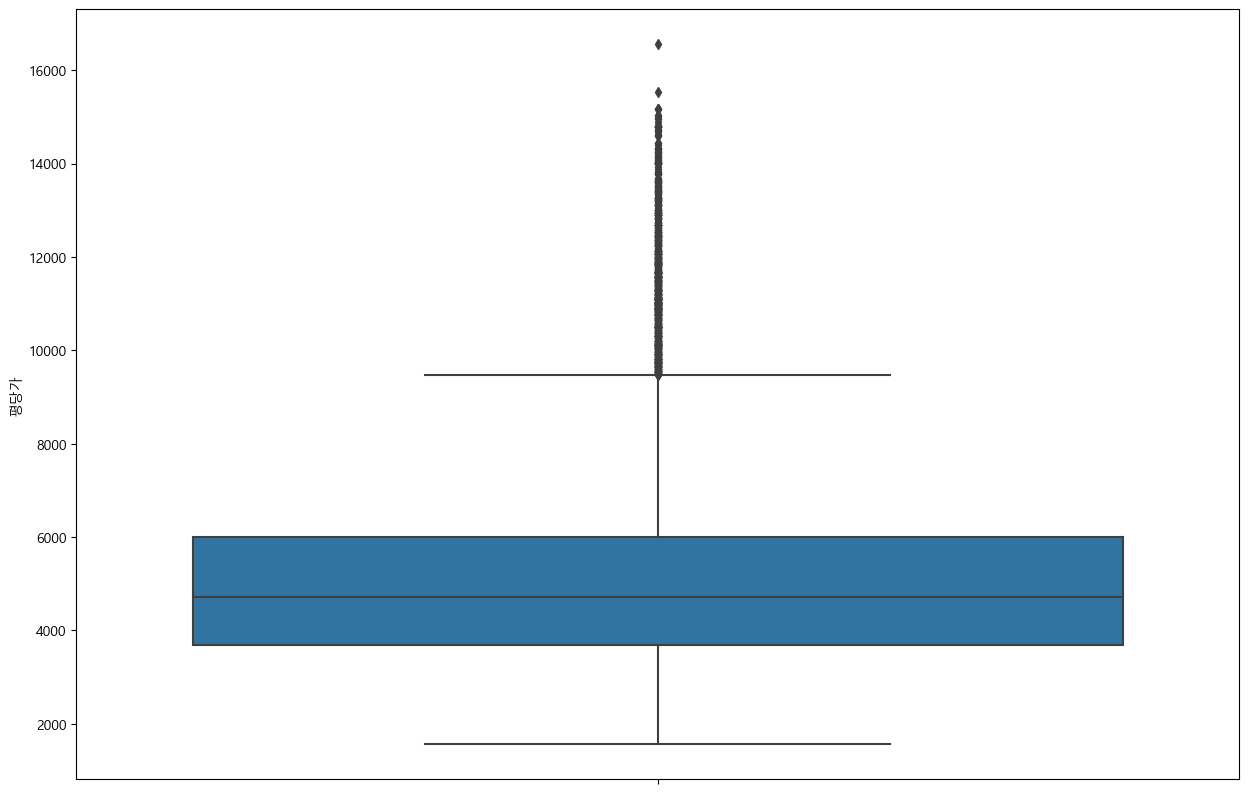

In [36]:

# 전체 이상치 확인

ax = plt.figure(figsize=(15,10))
ax = sns.boxplot(y='평당가',data=data)
#plt.xticks(rotation=90)
plt.show()



In [37]:
data[data['평당가']>10000].count()

아파트 브랜드                               767
단지명                                   767
층                                     767
건축년도                                  767
건설수주_건축(단위 백만원)                       767
건설수주_주택(단위 백만원)                       767
매매가격지수(아파트)                           767
경상수지(백만불)                             767
무역수지(백만불)                             767
대출금액(아파트)(억원)                         767
대출잔액(아파트)(억원)                         767
서울_신규_분양세대(단위: 세대)                    767
아파트 동(호)수_(단위: 호)                     767
생산자물가지수 총지수                           767
전규모(1인이상) 전체임금총액[원]                   767
소비자물가지수 총지수                           767
소비자물가지수 주택, 수도, 전기 및 연료               767
가계대출 (연리%)                            767
경기종합지수(2020=100)                      767
경제활동인구_ 실업률(단위: %)                    767
경제활동인구_고용률(단위: %)                     767
경제활동인구_취업자(단위: 천명)                    767
국제 주요국 주가지수(KOSPI)                    767
예금은행 대출금리(신규취급액 기준)_대출평균(연%)      

In [38]:
data_outlier_index = data[data['평당가'] > 10000].index
data.drop(index=data_outlier_index, inplace=True)

In [39]:
data.reset_index(drop=True, inplace=True)

- 사분위로 무조건 자를 것인지, 각 매칭 구별로 박스플롯 범위 내 값을 가진 데이터를 버릴 것인지
- 그렇게 진행했을 때 남은 데이터 크기가 충분한지

In [40]:
data.to_csv("top5_data_before_onehot_encoding.csv", index = False)

In [41]:
top5_data_before_onehot_encoding = pd.read_csv("top5_data_before_onehot_encoding.csv")
top5_data_before_onehot_encoding

,아파트 브랜드,단지명,층,건축년도,건설수주_건축(단위 백만원),건설수주_주택(단위 백만원),매매가격지수(아파트),경상수지(백만불),무역수지(백만불),대출금액(아파트)(억원),...,DOW Jones_change_rate,KRX300_close,KRX300_change_rate,KOSPI_close,KOSPI_change_rate,KOSDAQ_close,KOSDAQ_change_rate,계약연도,평당가,클러스터링_구
0,래미안,래미안블레스티지,8,2019,9277921.0,4933751.0,94.3,6708.0,3935.0,46672.995,...,-0.012474,1220.65,-5.51,1987.01,-6.23,610.73,-4.94,2020,9647.193456,cluster 2
1,래미안,래미안블레스티지,10,2019,9277921.0,4933751.0,94.3,6708.0,3935.0,46672.995,...,-0.012474,1220.65,-5.51,1987.01,-6.23,610.73,-4.94,2020,9495.929741,cluster 2
2,래미안,래미안블레스티지,9,2019,9277921.0,4933751.0,94.3,6708.0,3935.0,46672.995,...,-0.012474,1220.65,-5.51,1987.01,-6.23,610.73,-4.94,2020,9457.011996,cluster 2
3,래미안,래미안블레스티지,10,2019,7187557.0,5327314.0,94.3,-4024.0,-1663.0,20871.755,...,0.029000,1187.44,9.01,1947.56,10.99,645.18,13.37,2020,9922.827555,cluster 2
4,래미안,래미안블레스티지,10,2019,10945748.0,8624217.0,94.1,1942.0,193.0,18127.483,...,0.041948,1238.06,4.26,2029.60,4.21,713.68,10.62,2020,8951.081313,cluster 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17394,롯데캐슬,롯데캐슬,13,2008,14731854.0,10055966.0,96.3,2677.0,-4774.0,33635.767,...,0.001924,1316.55,-8.92,2236.40,-9.55,679.29,-6.89,2022,3476.293941,cluster 2
17395,롯데캐슬,롯데캐슬,22,2008,14731854.0,10055966.0,96.3,2677.0,-4774.0,33635.767,...,0.001924,1316.55,-8.92,2236.40,-9.55,679.29,-6.89,2022,3306.957161,cluster 2
17396,롯데캐슬,남산롯데캐슬아이리스,29,2011,19081016.0,9429872.0,104.1,6064.0,-2470.0,13267.086,...,-0.028807,1395.39,-13.61,2332.64,-13.15,745.44,-16.56,2022,5551.595387,cluster 2
17397,롯데캐슬,남산롯데캐슬아이리스,20,2011,13709893.0,7038729.0,103.4,-2912.0,-9422.0,8700.338,...,0.046749,1468.88,-0.18,2472.05,0.84,807.04,0.43,2022,5058.120242,cluster 2


In [43]:
top5_data_before_onehot_encoding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17399 entries, 0 to 17398
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   아파트 브랜드                             17399 non-null  object 
 1   단지명                                 17399 non-null  object 
 2   층                                   17399 non-null  int64  
 3   건축년도                                17399 non-null  int64  
 4   건설수주_건축(단위 백만원)                     17399 non-null  float64
 5   건설수주_주택(단위 백만원)                     17399 non-null  float64
 6   매매가격지수(아파트)                         17399 non-null  float64
 7   경상수지(백만불)                           17399 non-null  float64
 8   무역수지(백만불)                           17399 non-null  float64
 9   대출금액(아파트)(억원)                       17399 non-null  float64
 10  대출잔액(아파트)(억원)                       17399 non-null  float64
 11  서울_신규_분양세대(단위: 세대)                  17399

In [44]:
top5_data_before_onehot_encoding.columns

Index(['아파트 브랜드', '단지명', '층', '건축년도', '건설수주_건축(단위 백만원)', '건설수주_주택(단위 백만원)',
       '매매가격지수(아파트)', '경상수지(백만불)', '무역수지(백만불)', '대출금액(아파트)(억원)',
       '대출잔액(아파트)(억원)', '서울_신규_분양세대(단위: 세대)', '아파트 동(호)수_(단위: 호)',
       '생산자물가지수 총지수 ', '전규모(1인이상) 전체임금총액[원]', '소비자물가지수 총지수 ',
       '소비자물가지수 주택, 수도, 전기 및 연료', '가계대출 (연리%)', '경기종합지수(2020=100)',
       '경제활동인구_ 실업률(단위: %)', '경제활동인구_고용률(단위: %)', '경제활동인구_취업자(단위: 천명)',
       '국제 주요국 주가지수(KOSPI)', '예금은행 대출금리(신규취급액 기준)_대출평균(연%)',
       '예금은행 대출금리(잔액 기준)_총대출(연리%)', '주택매매가격지수(KB)_서울',
       '소비자물가지수_총지수(가중치:1000?)', '원화의 대미달러, 원화의 대위안/대엔 환율(원/달러(종가)_원',
       '경기종합지수', 'S&P 500_close', 'S&P 500_change_rate', 'NASDAQ_close',
       'NASDAQ_change_rate', 'DOW Jones_close', 'DOW Jones_change_rate',
       'KRX300_close', 'KRX300_change_rate', 'KOSPI_close',
       'KOSPI_change_rate', 'KOSDAQ_close', 'KOSDAQ_change_rate', '계약연도',
       '평당가', '클러스터링_구'],
      dtype='object')

In [45]:
top5_data_before_onehot_encoding_X_for_scale = top5_data_before_onehot_encoding[['건설수주_건축(단위 백만원)', '건설수주_주택(단위 백만원)',
       '매매가격지수(아파트)', '경상수지(백만불)', '무역수지(백만불)', '대출금액(아파트)(억원)',
       '대출잔액(아파트)(억원)', '서울_신규_분양세대(단위: 세대)', '아파트 동(호)수_(단위: 호)',
       '생산자물가지수 총지수 ', '전규모(1인이상) 전체임금총액[원]', '소비자물가지수 총지수 ',
       '소비자물가지수 주택, 수도, 전기 및 연료', '가계대출 (연리%)', '경기종합지수(2020=100)',
       '경제활동인구_ 실업률(단위: %)', '경제활동인구_고용률(단위: %)', '경제활동인구_취업자(단위: 천명)',
       '국제 주요국 주가지수(KOSPI)', '예금은행 대출금리(신규취급액 기준)_대출평균(연%)',
       '예금은행 대출금리(잔액 기준)_총대출(연리%)', '주택매매가격지수(KB)_서울',
       '소비자물가지수_총지수(가중치:1000?)', '원화의 대미달러, 원화의 대위안/대엔 환율(원/달러(종가)_원',
       '경기종합지수', 'S&P 500_close', 'S&P 500_change_rate', 'NASDAQ_close',
       'NASDAQ_change_rate', 'DOW Jones_close', 'DOW Jones_change_rate',
       'KRX300_close', 'KRX300_change_rate', 'KOSPI_close',
       'KOSPI_change_rate', 'KOSDAQ_close', 'KOSDAQ_change_rate']]
top5_data_before_onehot_encoding_not_for_scale = top5_data_before_onehot_encoding[['아파트 브랜드', '단지명', '층', '건축년도', '계약연도',
       '평당가', '클러스터링_구']]

In [46]:
scaler = StandardScaler()
top5_data_before_onehot_encoding_X_for_scale_std = scaler.fit_transform(top5_data_before_onehot_encoding_X_for_scale)
top5_data_before_onehot_encoding_X_for_scale_std = pd.DataFrame(top5_data_before_onehot_encoding_X_for_scale_std, columns=top5_data_before_onehot_encoding_X_for_scale.columns)
top5_data_before_onehot_encoding_X_for_scale_std

,건설수주_건축(단위 백만원),건설수주_주택(단위 백만원),매매가격지수(아파트),경상수지(백만불),무역수지(백만불),대출금액(아파트)(억원),대출잔액(아파트)(억원),서울_신규_분양세대(단위: 세대),아파트 동(호)수_(단위: 호),생산자물가지수 총지수,...,NASDAQ_close,NASDAQ_change_rate,DOW Jones_close,DOW Jones_change_rate,KRX300_close,KRX300_change_rate,KOSPI_close,KOSPI_change_rate,KOSDAQ_close,KOSDAQ_change_rate
0,-1.019756,-1.247423,-0.915257,-0.005871,0.344366,2.220223,2.000058,-0.438723,0.556187,-0.472297,...,-1.102716,-0.252213,-0.291367,-0.691149,-1.204236,-1.297652,-1.200996,-1.421285,-1.734966,-1.159820
1,-1.019756,-1.247423,-0.915257,-0.005871,0.344366,2.220223,2.000058,-0.438723,0.556187,-0.472297,...,-1.102716,-0.252213,-0.291367,-0.691149,-1.204236,-1.297652,-1.200996,-1.421285,-1.734966,-1.159820
2,-1.019756,-1.247423,-0.915257,-0.005871,0.344366,2.220223,2.000058,-0.438723,0.556187,-0.472297,...,-1.102716,-0.252213,-0.291367,-0.691149,-1.204236,-1.297652,-1.200996,-1.421285,-1.734966,-1.159820
3,-1.604618,-1.088408,-0.915257,-3.069260,-1.617715,-0.297035,-0.509550,-0.108071,-0.864173,-0.847407,...,-1.656881,0.634042,-1.743006,0.215699,-1.328129,1.108872,-1.288959,1.486886,-1.475152,1.725032
4,-0.553115,0.243674,-0.978563,-1.366299,-0.967193,-0.564776,-0.777441,-0.276758,-0.710746,-0.841190,...,-1.256796,1.223225,-1.471580,0.498808,-1.139287,0.321613,-1.106033,0.341857,-0.958541,1.291753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17394,0.506198,0.822159,-0.282197,-1.156497,-2.708111,0.948266,1.611120,-0.390070,-1.522275,2.853958,...,-0.404061,-0.864445,1.087131,-0.376319,-0.846475,-1.862821,-0.644928,-1.981978,-1.217903,-1.467054
17395,0.506198,0.822159,-0.282197,-1.156497,-2.708111,0.948266,1.611120,-0.390070,-1.522275,2.853958,...,-0.404061,-0.864445,1.087131,-0.376319,-0.846475,-1.862821,-0.644928,-1.981978,-1.217903,-1.467054
17396,1.723048,0.569192,2.186735,-0.189697,-1.900566,-1.038973,-0.990821,-0.412796,-1.275182,2.918204,...,-0.118762,-1.289341,0.521694,-1.048262,-0.552356,-2.640135,-0.430340,-2.589958,-0.719015,-2.990622
17397,0.220264,-0.396927,1.965164,-2.751846,-4.337220,-1.484521,-1.575508,-0.386229,-1.545204,2.893334,...,0.447651,0.910316,0.955825,0.603792,-0.278197,-0.414266,-0.119496,-0.227280,-0.254442,-0.313744


In [47]:
top5_data_before_onehot_encoding_std = pd.concat([top5_data_before_onehot_encoding_not_for_scale, top5_data_before_onehot_encoding_X_for_scale_std], axis=1)
top5_data_before_onehot_encoding_std.to_csv("top5_scaled_data_before_onehot_encoding.csv", index = False)

# 원핫인코딩

In [48]:
ohe = OneHotEncoder(sparse=False)

data_apt_brand = ohe.fit_transform(data[['아파트 브랜드']])
data_apt_brand

C:\Users\2001_\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [49]:
ohe.categories_

[array(['래미안', '롯데캐슬', '자이', '푸르지오', '힐스테이트'], dtype=object)]

In [50]:
data_apt_brand = pd.DataFrame(data_apt_brand, columns=['아파트 브랜드_' + col for col in ohe.categories_[0]])

In [51]:
data_transaction_year = ohe.fit_transform(data[['계약연도']])
data_transaction_year

C:\Users\2001_\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

In [52]:
ohe.categories_

[array(['2020', '2021', '2022'], dtype=object)]

In [53]:
data_transaction_year = pd.DataFrame(data_transaction_year, columns=['계약연도' + col for col in ohe.categories_[0]])

In [54]:
data_clustering_gu = ohe.fit_transform(data[['클러스터링_구']])
data_clustering_gu

C:\Users\2001_\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [55]:
ohe.categories_

[array(['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4', 'cluster 5'],
       dtype=object)]

In [56]:
data_clustering_gu = pd.DataFrame(data_clustering_gu, columns=[col for col in ohe.categories_[0]])

In [57]:
data = data.drop(columns=['아파트 브랜드'])
data = data.drop(columns=['계약연도'])
data = data.drop(columns=['단지명'])
data = data.drop(columns=['클러스터링_구'])

In [58]:
data = pd.concat([data_apt_brand, data_transaction_year, data_clustering_gu, data], axis=1)

In [59]:
pd.set_option('display.max_columns', None)  # 모든 열을 출력하도록 설정
pd.set_option('display.expand_frame_repr', False)  # 너비 제한 없이 출력
data

,아파트 브랜드_래미안,아파트 브랜드_롯데캐슬,아파트 브랜드_자이,아파트 브랜드_푸르지오,아파트 브랜드_힐스테이트,계약연도2020,계약연도2021,계약연도2022,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,층,건축년도,건설수주_건축(단위 백만원),건설수주_주택(단위 백만원),매매가격지수(아파트),경상수지(백만불),무역수지(백만불),대출금액(아파트)(억원),대출잔액(아파트)(억원),서울_신규_분양세대(단위: 세대),아파트 동(호)수_(단위: 호),생산자물가지수 총지수,전규모(1인이상) 전체임금총액[원],소비자물가지수 총지수,"소비자물가지수 주택, 수도, 전기 및 연료",가계대출 (연리%),경기종합지수(2020=100),경제활동인구_ 실업률(단위: %),경제활동인구_고용률(단위: %),경제활동인구_취업자(단위: 천명),국제 주요국 주가지수(KOSPI),예금은행 대출금리(신규취급액 기준)_대출평균(연%),예금은행 대출금리(잔액 기준)_총대출(연리%),주택매매가격지수(KB)_서울,소비자물가지수_총지수(가중치:1000?),"원화의 대미달러, 원화의 대위안/대엔 환율(원/달러(종가)_원",경기종합지수,S&P 500_close,S&P 500_change_rate,NASDAQ_close,NASDAQ_change_rate,DOW Jones_close,DOW Jones_change_rate,KRX300_close,KRX300_change_rate,KOSPI_close,KOSPI_change_rate,KOSDAQ_close,KOSDAQ_change_rate,평당가
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,8,2019,9277921.0,4933751.0,94.3,6708.0,3935.0,46672.995,35063.77793,67,9522,103.74,3403361,100.16,100.76,2.90,98.6,4.1,60.0,26838.0,1987.01,3.08,3.35,80.798,100.16,1195.16,98.6,3277.314183,-0.000271,9418.850021,0.020089,28519.731600,-0.012474,1220.65,-5.51,1987.01,-6.23,610.73,-4.94,9647.193456
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10,2019,9277921.0,4933751.0,94.3,6708.0,3935.0,46672.995,35063.77793,67,9522,103.74,3403361,100.16,100.76,2.90,98.6,4.1,60.0,26838.0,1987.01,3.08,3.35,80.798,100.16,1195.16,98.6,3277.314183,-0.000271,9418.850021,0.020089,28519.731600,-0.012474,1220.65,-5.51,1987.01,-6.23,610.73,-4.94,9495.929741
2,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,9,2019,9277921.0,4933751.0,94.3,6708.0,3935.0,46672.995,35063.77793,67,9522,103.74,3403361,100.16,100.76,2.90,98.6,4.1,60.0,26838.0,1987.01,3.08,3.35,80.798,100.16,1195.16,98.6,3277.314183,-0.000271,9418.850021,0.020089,28519.731600,-0.012474,1220.65,-5.51,1987.01,-6.23,610.73,-4.94,9457.011996
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10,2019,7187557.0,5327314.0,94.3,-4024.0,-1663.0,20871.755,16239.20130,1100,3699,101.93,3358565,99.50,100.56,2.89,98.5,4.2,59.4,26562.0,1947.56,2.80,3.21,81.310,99.50,1224.42,98.5,2761.975226,0.041314,8292.407180,0.066931,23293.899833,0.029000,1187.44,9.01,1947.56,10.99,645.18,13.37,9922.827555
4,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,10,2019,10945748.0,8624217.0,94.1,1942.0,193.0,18127.483,14229.74914,573,4328,101.96,3287099,99.44,100.20,2.81,98.5,4.5,60.2,26930.0,2029.60,2.82,3.14,81.326,99.44,1230.06,98.5,2919.608484,0.057073,9105.655469,0.098071,24271.021387,0.041948,1238.06,4.26,2029.60,4.21,713.68,10.62,8951.081313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17394,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,13,2008,14731854.0,10055966.0,96.3,2677.0,-4774.0,33635.767,32146.35769,219,1001,119.79,4433753,109.28,110.77,5.64,109.5,3.0,61.3,27808.0,2236.40,5.57,4.92,98.519,109.28,1294.42,109.5,3912.380952,-0.001304,10838.995815,-0.012270,33482.257254,0.001924,1316.55,-8.92,2236.40,-9.55,679.29,-6.89,3476.293941
17395,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,22,2008,14731854.0,10055966.0,96.3,2677.0,-4774.0,33635.767,32146.35769,219,1001,119.79,4433753,109.28,110.77,5.64,109.5,3.0,61.3,27808.0,2236.40,5.57,4.92,98.519,109.28,1294.42,109.5,3912.380952,-0.001304,10838.995815,-0.012270,33482.257254,0.001924,1316.55,-8.92,2236.40,-9.55,679.29,-6.89,3306.957161
17396,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,29,2011,19081016.0,9429872.0,104.1,6064.0,-2470.0,13267.086,12629.18263,148,2014,120.10,3662766,108.22,106.84,4.23,108.8,3.0,62.9,28478.0,2332.64,3.90,3.57,100.723,108.22,1280.83,108.8,3898.946684,-0.035000,11418.919085,-0.034727,31446.712798,-0.028807,1395.39,-13.61,2332.64,-13.15,745.44,-16.56,5551.595387
17397,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,20,2011,13709893.0,7038729.0,103.4,-2912.0,-9422.0,8700.338,8243.44211,231,907,119.98,3701953,108.

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17399 entries, 0 to 17398
Data columns (total 53 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   아파트 브랜드_래미안                         17399 non-null  float64
 1   아파트 브랜드_롯데캐슬                        17399 non-null  float64
 2   아파트 브랜드_자이                          17399 non-null  float64
 3   아파트 브랜드_푸르지오                        17399 non-null  float64
 4   아파트 브랜드_힐스테이트                       17399 non-null  float64
 5   계약연도2020                            17399 non-null  float64
 6   계약연도2021                            17399 non-null  float64
 7   계약연도2022                            17399 non-null  float64
 8   cluster 1                           17399 non-null  float64
 9   cluster 2                           17399 non-null  float64
 10  cluster 3                           17399 non-null  float64
 11  cluster 4                           17399

In [61]:
print("아파트 브랜드_래미안: ") 
print(data['아파트 브랜드_래미안'].sum())
print("아파트 브랜드_롯데캐슬: ")
print(data['아파트 브랜드_롯데캐슬'].sum())
print("아파트 브랜드_자이: ") 
print(data['아파트 브랜드_자이'].sum())
print("아파트 브랜드_푸르지오: ")
print(data['아파트 브랜드_푸르지오'].sum())
print("아파트 브랜드_힐스테이트: ")
print(data['아파트 브랜드_힐스테이트'].sum())
print("계약연도2020: ")
print(data['계약연도2020'].sum())
print("계약연도2021: ")
print(data['계약연도2021'].sum())
print("계약연도2022: ")
print(data['계약연도2022'].sum())
print("cluster 1: ")
print(data['cluster 1'].sum())
print("cluster 2: ")
print(data['cluster 2'].sum())
print("cluster 3: ") 
print(data['cluster 3'].sum())
print("cluster 4: ") 
print(data['cluster 4'].sum())
print("cluster 5: ")
print(data['cluster 5'].sum())

아파트 브랜드_래미안: 
7195.0
아파트 브랜드_롯데캐슬: 
2186.0
아파트 브랜드_자이: 
2270.0
아파트 브랜드_푸르지오: 
2901.0
아파트 브랜드_힐스테이트: 
2847.0
계약연도2020: 
10821.0
계약연도2021: 
5180.0
계약연도2022: 
1398.0
cluster 1: 
5385.0
cluster 2: 
8617.0
cluster 3: 
1388.0
cluster 4: 
1559.0
cluster 5: 
450.0


'아파트 브랜드_래미안', '계약연도2020', 'cluster 2' 삭제

In [62]:
data.drop(labels=['아파트 브랜드_래미안', '계약연도2020', 'cluster 2' ], axis=1, inplace=True)
data

,아파트 브랜드_롯데캐슬,아파트 브랜드_자이,아파트 브랜드_푸르지오,아파트 브랜드_힐스테이트,계약연도2021,계약연도2022,cluster 1,cluster 3,cluster 4,cluster 5,층,건축년도,건설수주_건축(단위 백만원),건설수주_주택(단위 백만원),매매가격지수(아파트),경상수지(백만불),무역수지(백만불),대출금액(아파트)(억원),대출잔액(아파트)(억원),서울_신규_분양세대(단위: 세대),아파트 동(호)수_(단위: 호),생산자물가지수 총지수,전규모(1인이상) 전체임금총액[원],소비자물가지수 총지수,"소비자물가지수 주택, 수도, 전기 및 연료",가계대출 (연리%),경기종합지수(2020=100),경제활동인구_ 실업률(단위: %),경제활동인구_고용률(단위: %),경제활동인구_취업자(단위: 천명),국제 주요국 주가지수(KOSPI),예금은행 대출금리(신규취급액 기준)_대출평균(연%),예금은행 대출금리(잔액 기준)_총대출(연리%),주택매매가격지수(KB)_서울,소비자물가지수_총지수(가중치:1000?),"원화의 대미달러, 원화의 대위안/대엔 환율(원/달러(종가)_원",경기종합지수,S&P 500_close,S&P 500_change_rate,NASDAQ_close,NASDAQ_change_rate,DOW Jones_close,DOW Jones_change_rate,KRX300_close,KRX300_change_rate,KOSPI_close,KOSPI_change_rate,KOSDAQ_close,KOSDAQ_change_rate,평당가
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,2019,9277921.0,4933751.0,94.3,6708.0,3935.0,46672.995,35063.77793,67,9522,103.74,3403361,100.16,100.76,2.90,98.6,4.1,60.0,26838.0,1987.01,3.08,3.35,80.798,100.16,1195.16,98.6,3277.314183,-0.000271,9418.850021,0.020089,28519.731600,-0.012474,1220.65,-5.51,1987.01,-6.23,610.73,-4.94,9647.193456
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,2019,9277921.0,4933751.0,94.3,6708.0,3935.0,46672.995,35063.77793,67,9522,103.74,3403361,100.16,100.76,2.90,98.6,4.1,60.0,26838.0,1987.01,3.08,3.35,80.798,100.16,1195.16,98.6,3277.314183,-0.000271,9418.850021,0.020089,28519.731600,-0.012474,1220.65,-5.51,1987.01,-6.23,610.73,-4.94,9495.929741
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,2019,9277921.0,4933751.0,94.3,6708.0,3935.0,46672.995,35063.77793,67,9522,103.74,3403361,100.16,100.76,2.90,98.6,4.1,60.0,26838.0,1987.01,3.08,3.35,80.798,100.16,1195.16,98.6,3277.314183,-0.000271,9418.850021,0.020089,28519.731600,-0.012474,1220.65,-5.51,1987.01,-6.23,610.73,-4.94,9457.011996
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,2019,7187557.0,5327314.0,94.3,-4024.0,-1663.0,20871.755,16239.20130,1100,3699,101.93,3358565,99.50,100.56,2.89,98.5,4.2,59.4,26562.0,1947.56,2.80,3.21,81.310,99.50,1224.42,98.5,2761.975226,0.041314,8292.407180,0.066931,23293.899833,0.029000,1187.44,9.01,1947.56,10.99,645.18,13.37,9922.827555
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,2019,10945748.0,8624217.0,94.1,1942.0,193.0,18127.483,14229.74914,573,4328,101.96,3287099,99.44,100.20,2.81,98.5,4.5,60.2,26930.0,2029.60,2.82,3.14,81.326,99.44,1230.06,98.5,2919.608484,0.057073,9105.655469,0.098071,24271.021387,0.041948,1238.06,4.26,2029.60,4.21,713.68,10.62,8951.081313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17394,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13,2008,14731854.0,10055966.0,96.3,2677.0,-4774.0,33635.767,32146.35769,219,1001,119.79,4433753,109.28,110.77,5.64,109.5,3.0,61.3,27808.0,2236.40,5.57,4.92,98.519,109.28,1294.42,109.5,3912.380952,-0.001304,10838.995815,-0.012270,33482.257254,0.001924,1316.55,-8.92,2236.40,-9.55,679.29,-6.89,3476.293941
17395,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,22,2008,14731854.0,10055966.0,96.3,2677.0,-4774.0,33635.767,32146.35769,219,1001,119.79,4433753,109.28,110.77,5.64,109.5,3.0,61.3,27808.0,2236.40,5.57,4.92,98.519,109.28,1294.42,109.5,3912.380952,-0.001304,10838.995815,-0.012270,33482.257254,0.001924,1316.55,-8.92,2236.40,-9.55,679.29,-6.89,3306.957161
17396,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,29,2011,19081016.0,9429872.0,104.1,6064.0,-2470.0,13267.086,12629.18263,148,2014,120.10,3662766,108.22,106.84,4.23,108.8,3.0,62.9,28478.0,2332.64,3.90,3.57,100.723,108.22,1280.83,108.8,3898.946684,-0.035000,11418.919085,-0.034727,31446.712798,-0.028807,1395.39,-13.61,2332.64,-13.15,745.44,-16.56,5551.595387
17397,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20,2011,13709893.0,7038729.0,103.4,-2912.0,-9422.0,8700.338,8243.44211,231,907,119.98,3701953,108.62,106.99,4.76,109.0,2.1,62.8,28410.0,2472.05,4.52,3.91,100.719,108.62,1320.35,109.0,4158.563084,0.063101,12570.260403,0.081533,33009.564878,0.046749,1

In [63]:
data.to_csv("top5_final_data.csv", index = False)

In [64]:
data_is_ok = pd.read_csv("./top5_final_data.csv")
data_is_ok

,아파트 브랜드_롯데캐슬,아파트 브랜드_자이,아파트 브랜드_푸르지오,아파트 브랜드_힐스테이트,계약연도2021,계약연도2022,cluster 1,cluster 3,cluster 4,cluster 5,층,건축년도,건설수주_건축(단위 백만원),건설수주_주택(단위 백만원),매매가격지수(아파트),경상수지(백만불),무역수지(백만불),대출금액(아파트)(억원),대출잔액(아파트)(억원),서울_신규_분양세대(단위: 세대),아파트 동(호)수_(단위: 호),생산자물가지수 총지수,전규모(1인이상) 전체임금총액[원],소비자물가지수 총지수,"소비자물가지수 주택, 수도, 전기 및 연료",가계대출 (연리%),경기종합지수(2020=100),경제활동인구_ 실업률(단위: %),경제활동인구_고용률(단위: %),경제활동인구_취업자(단위: 천명),국제 주요국 주가지수(KOSPI),예금은행 대출금리(신규취급액 기준)_대출평균(연%),예금은행 대출금리(잔액 기준)_총대출(연리%),주택매매가격지수(KB)_서울,소비자물가지수_총지수(가중치:1000?),"원화의 대미달러, 원화의 대위안/대엔 환율(원/달러(종가)_원",경기종합지수,S&P 500_close,S&P 500_change_rate,NASDAQ_close,NASDAQ_change_rate,DOW Jones_close,DOW Jones_change_rate,KRX300_close,KRX300_change_rate,KOSPI_close,KOSPI_change_rate,KOSDAQ_close,KOSDAQ_change_rate,평당가
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,2019,9277921.0,4933751.0,94.3,6708.0,3935.0,46672.995,35063.77793,67,9522,103.74,3403361,100.16,100.76,2.90,98.6,4.1,60.0,26838.0,1987.01,3.08,3.35,80.798,100.16,1195.16,98.6,3277.314183,-0.000271,9418.850021,0.020089,28519.731600,-0.012474,1220.65,-5.51,1987.01,-6.23,610.73,-4.94,9647.193456
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,2019,9277921.0,4933751.0,94.3,6708.0,3935.0,46672.995,35063.77793,67,9522,103.74,3403361,100.16,100.76,2.90,98.6,4.1,60.0,26838.0,1987.01,3.08,3.35,80.798,100.16,1195.16,98.6,3277.314183,-0.000271,9418.850021,0.020089,28519.731600,-0.012474,1220.65,-5.51,1987.01,-6.23,610.73,-4.94,9495.929741
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,2019,9277921.0,4933751.0,94.3,6708.0,3935.0,46672.995,35063.77793,67,9522,103.74,3403361,100.16,100.76,2.90,98.6,4.1,60.0,26838.0,1987.01,3.08,3.35,80.798,100.16,1195.16,98.6,3277.314183,-0.000271,9418.850021,0.020089,28519.731600,-0.012474,1220.65,-5.51,1987.01,-6.23,610.73,-4.94,9457.011996
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,2019,7187557.0,5327314.0,94.3,-4024.0,-1663.0,20871.755,16239.20130,1100,3699,101.93,3358565,99.50,100.56,2.89,98.5,4.2,59.4,26562.0,1947.56,2.80,3.21,81.310,99.50,1224.42,98.5,2761.975226,0.041314,8292.407180,0.066931,23293.899833,0.029000,1187.44,9.01,1947.56,10.99,645.18,13.37,9922.827555
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10,2019,10945748.0,8624217.0,94.1,1942.0,193.0,18127.483,14229.74914,573,4328,101.96,3287099,99.44,100.20,2.81,98.5,4.5,60.2,26930.0,2029.60,2.82,3.14,81.326,99.44,1230.06,98.5,2919.608484,0.057073,9105.655469,0.098071,24271.021387,0.041948,1238.06,4.26,2029.60,4.21,713.68,10.62,8951.081313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17394,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,13,2008,14731854.0,10055966.0,96.3,2677.0,-4774.0,33635.767,32146.35769,219,1001,119.79,4433753,109.28,110.77,5.64,109.5,3.0,61.3,27808.0,2236.40,5.57,4.92,98.519,109.28,1294.42,109.5,3912.380952,-0.001304,10838.995815,-0.012270,33482.257254,0.001924,1316.55,-8.92,2236.40,-9.55,679.29,-6.89,3476.293941
17395,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,22,2008,14731854.0,10055966.0,96.3,2677.0,-4774.0,33635.767,32146.35769,219,1001,119.79,4433753,109.28,110.77,5.64,109.5,3.0,61.3,27808.0,2236.40,5.57,4.92,98.519,109.28,1294.42,109.5,3912.380952,-0.001304,10838.995815,-0.012270,33482.257254,0.001924,1316.55,-8.92,2236.40,-9.55,679.29,-6.89,3306.957161
17396,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,29,2011,19081016.0,9429872.0,104.1,6064.0,-2470.0,13267.086,12629.18263,148,2014,120.10,3662766,108.22,106.84,4.23,108.8,3.0,62.9,28478.0,2332.64,3.90,3.57,100.723,108.22,1280.83,108.8,3898.946684,-0.035000,11418.919085,-0.034727,31446.712798,-0.028807,1395.39,-13.61,2332.64,-13.15,745.44,-16.56,5551.595387
17397,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,20,2011,13709893.0,7038729.0,103.4,-2912.0,-9422.0,8700.338,8243.44211,231,907,119.98,3701953,108.62,106.99,4.76,109.0,2.1,62.8,28410.0,2472.05,4.52,3.91,100.719,108.62,1320.35,109.0,4158.563084,0.063101,12570.260403,0.081533,33009.564878,0.046749,1

# 정규화

In [65]:
data.columns

Index(['아파트 브랜드_롯데캐슬', '아파트 브랜드_자이', '아파트 브랜드_푸르지오', '아파트 브랜드_힐스테이트',
       '계약연도2021', '계약연도2022', 'cluster 1', 'cluster 3', 'cluster 4',
       'cluster 5', '층', '건축년도', '건설수주_건축(단위 백만원)', '건설수주_주택(단위 백만원)',
       '매매가격지수(아파트)', '경상수지(백만불)', '무역수지(백만불)', '대출금액(아파트)(억원)',
       '대출잔액(아파트)(억원)', '서울_신규_분양세대(단위: 세대)', '아파트 동(호)수_(단위: 호)',
       '생산자물가지수 총지수 ', '전규모(1인이상) 전체임금총액[원]', '소비자물가지수 총지수 ',
       '소비자물가지수 주택, 수도, 전기 및 연료', '가계대출 (연리%)', '경기종합지수(2020=100)',
       '경제활동인구_ 실업률(단위: %)', '경제활동인구_고용률(단위: %)', '경제활동인구_취업자(단위: 천명)',
       '국제 주요국 주가지수(KOSPI)', '예금은행 대출금리(신규취급액 기준)_대출평균(연%)',
       '예금은행 대출금리(잔액 기준)_총대출(연리%)', '주택매매가격지수(KB)_서울',
       '소비자물가지수_총지수(가중치:1000?)', '원화의 대미달러, 원화의 대위안/대엔 환율(원/달러(종가)_원',
       '경기종합지수', 'S&P 500_close', 'S&P 500_change_rate', 'NASDAQ_close',
       'NASDAQ_change_rate', 'DOW Jones_close', 'DOW Jones_change_rate',
       'KRX300_close', 'KRX300_change_rate', 'KOSPI_close',
       'KOSPI_change_rate', 'KOSDAQ_close', 'KOSDAQ_change_rat

In [66]:
X_dummy = data[['아파트 브랜드_롯데캐슬', '아파트 브랜드_자이', '아파트 브랜드_푸르지오', '아파트 브랜드_힐스테이트',
       '계약연도2021', '계약연도2022', 'cluster 1', 'cluster 3', 'cluster 4',
       'cluster 5']]

In [67]:
X_without_dummy = data[['층', '건축년도', '건설수주_건축(단위 백만원)', '건설수주_주택(단위 백만원)',
       '매매가격지수(아파트)', '경상수지(백만불)', '무역수지(백만불)', '대출금액(아파트)(억원)',
       '대출잔액(아파트)(억원)', '서울_신규_분양세대(단위: 세대)', '아파트 동(호)수_(단위: 호)',
       '생산자물가지수 총지수 ', '전규모(1인이상) 전체임금총액[원]', '소비자물가지수 총지수 ',
       '소비자물가지수 주택, 수도, 전기 및 연료', '가계대출 (연리%)', '경기종합지수(2020=100)',
       '경제활동인구_ 실업률(단위: %)', '경제활동인구_고용률(단위: %)', '경제활동인구_취업자(단위: 천명)',
       '국제 주요국 주가지수(KOSPI)', '예금은행 대출금리(신규취급액 기준)_대출평균(연%)',
       '예금은행 대출금리(잔액 기준)_총대출(연리%)', '주택매매가격지수(KB)_서울',
       '소비자물가지수_총지수(가중치:1000?)', '원화의 대미달러, 원화의 대위안/대엔 환율(원/달러(종가)_원',
       '경기종합지수', 'S&P 500_close', 'S&P 500_change_rate', 'NASDAQ_close',
       'NASDAQ_change_rate', 'DOW Jones_close', 'DOW Jones_change_rate',
       'KRX300_close', 'KRX300_change_rate', 'KOSPI_close',
       'KOSPI_change_rate', 'KOSDAQ_close', 'KOSDAQ_change_rate']]
X = data[['아파트 브랜드_롯데캐슬', '아파트 브랜드_자이', '아파트 브랜드_푸르지오', '아파트 브랜드_힐스테이트',
       '계약연도2021', '계약연도2022', 'cluster 1', 'cluster 3', 'cluster 4',
       'cluster 5', '층', '건축년도', '건설수주_건축(단위 백만원)', '건설수주_주택(단위 백만원)',
       '매매가격지수(아파트)', '경상수지(백만불)', '무역수지(백만불)', '대출금액(아파트)(억원)',
       '대출잔액(아파트)(억원)', '서울_신규_분양세대(단위: 세대)', '아파트 동(호)수_(단위: 호)',
       '생산자물가지수 총지수 ', '전규모(1인이상) 전체임금총액[원]', '소비자물가지수 총지수 ',
       '소비자물가지수 주택, 수도, 전기 및 연료', '가계대출 (연리%)', '경기종합지수(2020=100)',
       '경제활동인구_ 실업률(단위: %)', '경제활동인구_고용률(단위: %)', '경제활동인구_취업자(단위: 천명)',
       '국제 주요국 주가지수(KOSPI)', '예금은행 대출금리(신규취급액 기준)_대출평균(연%)',
       '예금은행 대출금리(잔액 기준)_총대출(연리%)', '주택매매가격지수(KB)_서울',
       '소비자물가지수_총지수(가중치:1000?)', '원화의 대미달러, 원화의 대위안/대엔 환율(원/달러(종가)_원',
       '경기종합지수', 'S&P 500_close', 'S&P 500_change_rate', 'NASDAQ_close',
       'NASDAQ_change_rate', 'DOW Jones_close', 'DOW Jones_change_rate',
       'KRX300_close', 'KRX300_change_rate', 'KOSPI_close',
       'KOSPI_change_rate', 'KOSDAQ_close', 'KOSDAQ_change_rate']]
X = pd.DataFrame(X)
y = data[['평당가']]

In [68]:
X['서울_신규_분양세대(단위: 세대)'] = X['서울_신규_분양세대(단위: 세대)'].astype(float)

In [69]:
scaler = StandardScaler()
X_std = scaler.fit_transform(X_without_dummy)

In [70]:
X_std

array([[-0.40295642,  1.53053241, -1.01975597, ..., -1.42128487,
        -1.73496624, -1.15981985],
       [-0.11878656,  1.53053241, -1.01975597, ..., -1.42128487,
        -1.73496624, -1.15981985],
       [-0.26087149,  1.53053241, -1.01975597, ..., -1.42128487,
        -1.73496624, -1.15981985],
       ...,
       [ 2.58082712,  0.20868695,  1.72304782, ..., -2.58995751,
        -0.71901472, -2.99062166],
       [ 1.30206274,  0.20868695,  0.2202636 , ..., -0.22727974,
        -0.25444184, -0.31374363],
       [ 2.72291205,  0.20868695,  0.2202636 , ..., -0.22727974,
        -0.25444184, -0.31374363]])

In [71]:
X_std = pd.DataFrame(X_std, columns=X_without_dummy.columns)
X_std

,층,건축년도,건설수주_건축(단위 백만원),건설수주_주택(단위 백만원),매매가격지수(아파트),경상수지(백만불),무역수지(백만불),대출금액(아파트)(억원),대출잔액(아파트)(억원),서울_신규_분양세대(단위: 세대),아파트 동(호)수_(단위: 호),생산자물가지수 총지수,전규모(1인이상) 전체임금총액[원],소비자물가지수 총지수,"소비자물가지수 주택, 수도, 전기 및 연료",가계대출 (연리%),경기종합지수(2020=100),경제활동인구_ 실업률(단위: %),경제활동인구_고용률(단위: %),경제활동인구_취업자(단위: 천명),국제 주요국 주가지수(KOSPI),예금은행 대출금리(신규취급액 기준)_대출평균(연%),예금은행 대출금리(잔액 기준)_총대출(연리%),주택매매가격지수(KB)_서울,소비자물가지수_총지수(가중치:1000?),"원화의 대미달러, 원화의 대위안/대엔 환율(원/달러(종가)_원",경기종합지수,S&P 500_close,S&P 500_change_rate,NASDAQ_close,NASDAQ_change_rate,DOW Jones_close,DOW Jones_change_rate,KRX300_close,KRX300_change_rate,KOSPI_close,KOSPI_change_rate,KOSDAQ_close,KOSDAQ_change_rate
0,-0.402956,1.530532,-1.019756,-1.247423,-0.915257,-0.005871,0.344366,2.220223,2.000058,-0.438723,0.556187,-0.472297,-0.671932,-0.484667,-0.035190,-0.098502,-1.090295,0.342380,-0.337465,-0.514050,-1.200996,0.381475,1.023713,-1.097700,-0.484667,0.380297,-1.090295,-0.630158,-0.535340,-1.102716,-0.252213,-0.291367,-0.691149,-1.204236,-1.297652,-1.200996,-1.421285,-1.734966,-1.159820
1,-0.118787,1.530532,-1.019756,-1.247423,-0.915257,-0.005871,0.344366,2.220223,2.000058,-0.438723,0.556187,-0.472297,-0.671932,-0.484667,-0.035190,-0.098502,-1.090295,0.342380,-0.337465,-0.514050,-1.200996,0.381475,1.023713,-1.097700,-0.484667,0.380297,-1.090295,-0.630158,-0.535340,-1.102716,-0.252213,-0.291367,-0.691149,-1.204236,-1.297652,-1.200996,-1.421285,-1.734966,-1.159820
2,-0.260871,1.530532,-1.019756,-1.247423,-0.915257,-0.005871,0.344366,2.220223,2.000058,-0.438723,0.556187,-0.472297,-0.671932,-0.484667,-0.035190,-0.098502,-1.090295,0.342380,-0.337465,-0.514050,-1.200996,0.381475,1.023713,-1.097700,-0.484667,0.380297,-1.090295,-0.630158,-0.535340,-1.102716,-0.252213,-0.291367,-0.691149,-1.204236,-1.297652,-1.200996,-1.421285,-1.734966,-1.159820
3,-0.118787,1.530532,-1.604618,-1.088408,-0.915257,-3.069260,-1.617715,-0.297035,-0.509550,-0.108071,-0.864173,-0.847407,-0.830197,-0.782356,-0.126840,-0.117332,-1.118410,0.484154,-0.916294,-1.043358,-1.288959,-0.229474,0.588089,-1.019080,-0.782356,0.924541,-1.118410,-1.621744,0.422102,-1.656881,0.634042,-1.743006,0.215699,-1.328129,1.108872,-1.288959,1.486886,-1.475152,1.725032
4,-0.118787,1.530532,-0.553115,0.243674,-0.978563,-1.366299,-0.967193,-0.564776,-0.777441,-0.276758,-0.710746,-0.841190,-1.082687,-0.809419,-0.291812,-0.267973,-1.118410,0.909477,-0.144522,-0.337614,-1.106033,-0.185835,0.370277,-1.016623,-0.809419,1.029447,-1.118410,-1.318435,0.784917,-1.256796,1.223225,-1.471580,0.498808,-1.139287,0.321613,-1.106033,0.341857,-0.958541,1.291753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17394,0.307468,-0.287005,0.506198,0.822159,-0.282197,-1.156497,-2.708111,0.948266,1.611120,-0.390070,-1.522275,2.853958,2.968460,3.628851,4.551931,5.060949,1.974219,-1.217137,0.916665,1.346197,-0.644928,5.814551,5.908925,1.623436,3.628851,2.226560,1.974219,0.591801,-0.559117,-0.404061,-0.864445,1.087131,-0.376319,-0.846475,-1.862821,-0.644928,-1.981978,-1.217903,-1.467054
17395,1.586233,-0.287005,0.506198,0.822159,-0.282197,-1.156497,-2.708111,0.948266,1.611120,-0.390070,-1.522275,2.853958,2.968460,3.628851,4.551931,5.060949,1.974219,-1.217137,0.916665,1.346197,-0.644928,5.814551,5.908925,1.623436,3.628851,2.226560,1.974219,0.591801,-0.559117,-0.404061,-0.864445,1.087131,-0.376319,-0.846475,-1.862821,-0.644928,-1.981978,-1.217903,-1.467054
17396,2.580827,0.208687,1.723048,0.569192,2.186735,-0.189697,-1.900566,-1.038973,-0.990821,-0.412796,-1.275182,2.918204,0.244550,3.150744,2.750994,2.405903,1.777416,-1.217137,2.460210,2.631110,-0.430340,2.170681,1.708265,1.961870,3.150744,1.973782,1.777416,0.565952,-1.334927,-0.118762,-1.289341,0.521694,-1.048262,-0.552356,-2.640135,-0.430340,-2.589958,-0.719015,-2.990622
17397,1.302063,0.208687,0.220264,-0.396927,1.965164,-2.751846,-4.337220,-1.484521,-1.575508,-0.386229,-1.545204,2.893334,0.382999,3.331162,2.819732,3.403899,

In [72]:
X_std_final = pd.concat([X_dummy, X_std], axis=1)
X_std_final

,아파트 브랜드_롯데캐슬,아파트 브랜드_자이,아파트 브랜드_푸르지오,아파트 브랜드_힐스테이트,계약연도2021,계약연도2022,cluster 1,cluster 3,cluster 4,cluster 5,층,건축년도,건설수주_건축(단위 백만원),건설수주_주택(단위 백만원),매매가격지수(아파트),경상수지(백만불),무역수지(백만불),대출금액(아파트)(억원),대출잔액(아파트)(억원),서울_신규_분양세대(단위: 세대),아파트 동(호)수_(단위: 호),생산자물가지수 총지수,전규모(1인이상) 전체임금총액[원],소비자물가지수 총지수,"소비자물가지수 주택, 수도, 전기 및 연료",가계대출 (연리%),경기종합지수(2020=100),경제활동인구_ 실업률(단위: %),경제활동인구_고용률(단위: %),경제활동인구_취업자(단위: 천명),국제 주요국 주가지수(KOSPI),예금은행 대출금리(신규취급액 기준)_대출평균(연%),예금은행 대출금리(잔액 기준)_총대출(연리%),주택매매가격지수(KB)_서울,소비자물가지수_총지수(가중치:1000?),"원화의 대미달러, 원화의 대위안/대엔 환율(원/달러(종가)_원",경기종합지수,S&P 500_close,S&P 500_change_rate,NASDAQ_close,NASDAQ_change_rate,DOW Jones_close,DOW Jones_change_rate,KRX300_close,KRX300_change_rate,KOSPI_close,KOSPI_change_rate,KOSDAQ_close,KOSDAQ_change_rate
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.402956,1.530532,-1.019756,-1.247423,-0.915257,-0.005871,0.344366,2.220223,2.000058,-0.438723,0.556187,-0.472297,-0.671932,-0.484667,-0.035190,-0.098502,-1.090295,0.342380,-0.337465,-0.514050,-1.200996,0.381475,1.023713,-1.097700,-0.484667,0.380297,-1.090295,-0.630158,-0.535340,-1.102716,-0.252213,-0.291367,-0.691149,-1.204236,-1.297652,-1.200996,-1.421285,-1.734966,-1.159820
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.118787,1.530532,-1.019756,-1.247423,-0.915257,-0.005871,0.344366,2.220223,2.000058,-0.438723,0.556187,-0.472297,-0.671932,-0.484667,-0.035190,-0.098502,-1.090295,0.342380,-0.337465,-0.514050,-1.200996,0.381475,1.023713,-1.097700,-0.484667,0.380297,-1.090295,-0.630158,-0.535340,-1.102716,-0.252213,-0.291367,-0.691149,-1.204236,-1.297652,-1.200996,-1.421285,-1.734966,-1.159820
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.260871,1.530532,-1.019756,-1.247423,-0.915257,-0.005871,0.344366,2.220223,2.000058,-0.438723,0.556187,-0.472297,-0.671932,-0.484667,-0.035190,-0.098502,-1.090295,0.342380,-0.337465,-0.514050,-1.200996,0.381475,1.023713,-1.097700,-0.484667,0.380297,-1.090295,-0.630158,-0.535340,-1.102716,-0.252213,-0.291367,-0.691149,-1.204236,-1.297652,-1.200996,-1.421285,-1.734966,-1.159820
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.118787,1.530532,-1.604618,-1.088408,-0.915257,-3.069260,-1.617715,-0.297035,-0.509550,-0.108071,-0.864173,-0.847407,-0.830197,-0.782356,-0.126840,-0.117332,-1.118410,0.484154,-0.916294,-1.043358,-1.288959,-0.229474,0.588089,-1.019080,-0.782356,0.924541,-1.118410,-1.621744,0.422102,-1.656881,0.634042,-1.743006,0.215699,-1.328129,1.108872,-1.288959,1.486886,-1.475152,1.725032
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.118787,1.530532,-0.553115,0.243674,-0.978563,-1.366299,-0.967193,-0.564776,-0.777441,-0.276758,-0.710746,-0.841190,-1.082687,-0.809419,-0.291812,-0.267973,-1.118410,0.909477,-0.144522,-0.337614,-1.106033,-0.185835,0.370277,-1.016623,-0.809419,1.029447,-1.118410,-1.318435,0.784917,-1.256796,1.223225,-1.471580,0.498808,-1.139287,0.321613,-1.106033,0.341857,-0.958541,1.291753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17394,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.307468,-0.287005,0.506198,0.822159,-0.282197,-1.156497,-2.708111,0.948266,1.611120,-0.390070,-1.522275,2.853958,2.968460,3.628851,4.551931,5.060949,1.974219,-1.217137,0.916665,1.346197,-0.644928,5.814551,5.908925,1.623436,3.628851,2.226560,1.974219,0.591801,-0.559117,-0.404061,-0.864445,1.087131,-0.376319,-0.846475,-1.862821,-0.644928,-1.981978,-1.217903,-1.467054
17395,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.586233,-0.287005,0.506198,0.822159,-0.282197,-1.156497,-2.708111,0.948266,1.611120,-0.390070,-1.522275,2.853958,2.968460,3.628851,4.551931,5.060949,1.974219,-1.217137,0.916665,1.346197,-0.644928,5.814551,5.908925,1.623436,3.628851,2.226560,1.974219,0.591801,-0.559117,-0.404061,-0.864445,1.087131,-0.376319,-0.846475,-1.862821,-0.644928,-1.981978,-1.217903,-1.467054
17396,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.580827,0.208687,1.723048,0.569192,2.186735,-0.189697,-1

In [73]:
#y = pd.DataFrame({'평당가': y}, index=X_std_final.index)
scaled_data = pd.concat([X_std_final, y], axis=1)
scaled_data.to_csv("top5_final_scaled_data.csv",index = False)

In [74]:
data_is_ok_2 = pd.read_csv("./top5_final_scaled_data.csv")
data_is_ok_2

,아파트 브랜드_롯데캐슬,아파트 브랜드_자이,아파트 브랜드_푸르지오,아파트 브랜드_힐스테이트,계약연도2021,계약연도2022,cluster 1,cluster 3,cluster 4,cluster 5,층,건축년도,건설수주_건축(단위 백만원),건설수주_주택(단위 백만원),매매가격지수(아파트),경상수지(백만불),무역수지(백만불),대출금액(아파트)(억원),대출잔액(아파트)(억원),서울_신규_분양세대(단위: 세대),아파트 동(호)수_(단위: 호),생산자물가지수 총지수,전규모(1인이상) 전체임금총액[원],소비자물가지수 총지수,"소비자물가지수 주택, 수도, 전기 및 연료",가계대출 (연리%),경기종합지수(2020=100),경제활동인구_ 실업률(단위: %),경제활동인구_고용률(단위: %),경제활동인구_취업자(단위: 천명),국제 주요국 주가지수(KOSPI),예금은행 대출금리(신규취급액 기준)_대출평균(연%),예금은행 대출금리(잔액 기준)_총대출(연리%),주택매매가격지수(KB)_서울,소비자물가지수_총지수(가중치:1000?),"원화의 대미달러, 원화의 대위안/대엔 환율(원/달러(종가)_원",경기종합지수,S&P 500_close,S&P 500_change_rate,NASDAQ_close,NASDAQ_change_rate,DOW Jones_close,DOW Jones_change_rate,KRX300_close,KRX300_change_rate,KOSPI_close,KOSPI_change_rate,KOSDAQ_close,KOSDAQ_change_rate,평당가
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.402956,1.530532,-1.019756,-1.247423,-0.915257,-0.005871,0.344366,2.220223,2.000058,-0.438723,0.556187,-0.472297,-0.671932,-0.484667,-0.035190,-0.098502,-1.090295,0.342380,-0.337465,-0.514050,-1.200996,0.381475,1.023713,-1.097700,-0.484667,0.380297,-1.090295,-0.630158,-0.535340,-1.102716,-0.252213,-0.291367,-0.691149,-1.204236,-1.297652,-1.200996,-1.421285,-1.734966,-1.159820,9647.193456
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.118787,1.530532,-1.019756,-1.247423,-0.915257,-0.005871,0.344366,2.220223,2.000058,-0.438723,0.556187,-0.472297,-0.671932,-0.484667,-0.035190,-0.098502,-1.090295,0.342380,-0.337465,-0.514050,-1.200996,0.381475,1.023713,-1.097700,-0.484667,0.380297,-1.090295,-0.630158,-0.535340,-1.102716,-0.252213,-0.291367,-0.691149,-1.204236,-1.297652,-1.200996,-1.421285,-1.734966,-1.159820,9495.929741
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.260871,1.530532,-1.019756,-1.247423,-0.915257,-0.005871,0.344366,2.220223,2.000058,-0.438723,0.556187,-0.472297,-0.671932,-0.484667,-0.035190,-0.098502,-1.090295,0.342380,-0.337465,-0.514050,-1.200996,0.381475,1.023713,-1.097700,-0.484667,0.380297,-1.090295,-0.630158,-0.535340,-1.102716,-0.252213,-0.291367,-0.691149,-1.204236,-1.297652,-1.200996,-1.421285,-1.734966,-1.159820,9457.011996
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.118787,1.530532,-1.604618,-1.088408,-0.915257,-3.069260,-1.617715,-0.297035,-0.509550,-0.108071,-0.864173,-0.847407,-0.830197,-0.782356,-0.126840,-0.117332,-1.118410,0.484154,-0.916294,-1.043358,-1.288959,-0.229474,0.588089,-1.019080,-0.782356,0.924541,-1.118410,-1.621744,0.422102,-1.656881,0.634042,-1.743006,0.215699,-1.328129,1.108872,-1.288959,1.486886,-1.475152,1.725032,9922.827555
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.118787,1.530532,-0.553115,0.243674,-0.978563,-1.366299,-0.967193,-0.564776,-0.777441,-0.276758,-0.710746,-0.841190,-1.082687,-0.809419,-0.291812,-0.267973,-1.118410,0.909477,-0.144522,-0.337614,-1.106033,-0.185835,0.370277,-1.016623,-0.809419,1.029447,-1.118410,-1.318435,0.784917,-1.256796,1.223225,-1.471580,0.498808,-1.139287,0.321613,-1.106033,0.341857,-0.958541,1.291753,8951.081313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17394,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.307468,-0.287005,0.506198,0.822159,-0.282197,-1.156497,-2.708111,0.948266,1.611120,-0.390070,-1.522275,2.853958,2.968460,3.628851,4.551931,5.060949,1.974219,-1.217137,0.916665,1.346197,-0.644928,5.814551,5.908925,1.623436,3.628851,2.226560,1.974219,0.591801,-0.559117,-0.404061,-0.864445,1.087131,-0.376319,-0.846475,-1.862821,-0.644928,-1.981978,-1.217903,-1.467054,3476.293941
17395,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.586233,-0.287005,0.506198,0.822159,-0.282197,-1.156497,-2.708111,0.948266,1.611120,-0.390070,-1.522275,2.853958,2.968460,3.628851,4.551931,5.060949,1.974219,-1.217137,0.916665,1.346197,-0.644928,5.814551,5.908925,1.623436,3.628851,2.226560,1.974219,0.591801,-0.559117,-0.404061,-0.864445,1.087131,-0.376319,-0.846475,-1.862821,-0.644928,-1.981978,-1.217903,-1.467054,3306.957161
17396,1.0,0

# 상관계수 및 히트맵

In [75]:
pd.set_option('display.max_columns', None)  # 모든 열을 출력하도록 설정
pd.set_option('display.expand_frame_repr', False)  # 너비 제한 없이 출력
data_corr = data.corr()
data_corr

C:\Users\2001_\AppData\Local\Temp\ipykernel_18636\73757064.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data_corr = data.corr()


,아파트 브랜드_롯데캐슬,아파트 브랜드_자이,아파트 브랜드_푸르지오,아파트 브랜드_힐스테이트,계약연도2021,계약연도2022,cluster 1,cluster 3,cluster 4,cluster 5,층,건축년도,건설수주_건축(단위 백만원),건설수주_주택(단위 백만원),매매가격지수(아파트),경상수지(백만불),무역수지(백만불),대출금액(아파트)(억원),대출잔액(아파트)(억원),아파트 동(호)수_(단위: 호),생산자물가지수 총지수,전규모(1인이상) 전체임금총액[원],소비자물가지수 총지수,"소비자물가지수 주택, 수도, 전기 및 연료",가계대출 (연리%),경기종합지수(2020=100),경제활동인구_ 실업률(단위: %),경제활동인구_고용률(단위: %),경제활동인구_취업자(단위: 천명),국제 주요국 주가지수(KOSPI),예금은행 대출금리(신규취급액 기준)_대출평균(연%),예금은행 대출금리(잔액 기준)_총대출(연리%),주택매매가격지수(KB)_서울,소비자물가지수_총지수(가중치:1000?),"원화의 대미달러, 원화의 대위안/대엔 환율(원/달러(종가)_원",경기종합지수,S&P 500_close,S&P 500_change_rate,NASDAQ_close,NASDAQ_change_rate,DOW Jones_close,DOW Jones_change_rate,KRX300_close,KRX300_change_rate,KOSPI_close,KOSPI_change_rate,KOSDAQ_close,KOSDAQ_change_rate,평당가
아파트 브랜드_롯데캐슬,1.000000,-0.146834,-0.169565,-0.167668,0.024722,0.012986,-0.000963,-0.041849,-0.066101,-0.061766,0.121528,0.043521,0.001551,-0.007895,0.014326,-0.012654,-0.022809,0.009700,0.013432,-0.022484,0.021703,0.016978,0.021737,0.027428,0.022833,0.022947,0.015270,-0.007675,-0.002526,0.018586,0.019865,0.011575,0.020835,0.021737,-0.006156,0.022947,0.019074,-0.006587,0.014568,-0.009457,0.022224,-0.004733,0.017838,-0.018795,0.018586,-0.017043,0.005688,-0.024264,-0.039182
아파트 브랜드_자이,-0.146834,1.000000,-0.173272,-0.171333,0.031041,0.032396,-0.105409,0.088116,-0.085077,-0.000764,0.071651,0.180674,-0.009278,-0.019786,0.050627,-0.002849,-0.022262,-0.017115,-0.012253,-0.041018,0.047014,0.015640,0.045630,0.032818,0.032175,0.046196,-0.025983,0.022740,0.029576,0.033640,0.020678,0.000572,0.048467,0.045630,0.003507,0.046196,0.046256,-0.020675,0.040593,-0.033278,0.044457,-0.017095,0.031875,-0.028522,0.033640,-0.025305,0.030137,-0.026619,0.137635
아파트 브랜드_푸르지오,-0.169565,-0.173272,1.000000,-0.197857,-0.012032,-0.004024,-0.004957,0.049269,-0.077169,0.102944,-0.054428,-0.128256,-0.014224,-0.013358,-0.007611,-0.015065,-0.004561,0.009644,0.005848,0.001500,-0.008895,-0.009590,-0.010278,-0.004979,-0.004383,-0.013747,-0.001840,0.001474,-0.001727,-0.014584,-0.002380,0.002977,-0.012156,-0.010278,0.005830,-0.013747,-0.013166,-0.004236,-0.015055,-0.001079,-0.013307,-0.004958,-0.014759,0.003123,-0.014584,0.002882,-0.015490,0.006160,-0.176579
아파트 브랜드_힐스테이트,-0.167668,-0.171333,-0.197857,1.000000,-0.011078,-0.023293,0.129674,-0.061996,-0.040851,0.033638,-0.112430,0.133738,-0.014536,-0.002626,-0.027844,-0.008235,0.004900,-0.000238,-0.005927,0.037866,-0.028549,-0.000396,-0.030636,-0.037512,-0.027713,-0.029929,0.013952,-0.010162,-0.015083,-0.015721,-0.020565,-0.006875,-0.031568,-0.030636,-0.001081,-0.029929,-0.023953,0.018688,-0.020026,0.030053,-0.023580,0.009170,-0.015028,0.012496,-0.015721,0.012030,-0.011203,0.021490,-0.078880
계약연도2021,0.024722,0.031041,-0.012032,-0.011078,1.000000,-0.192454,0.008643,0.003139,-0.015026,-0.005522,0.013509,0.039156,-0.094011,-0.264656,0.568530,0.089769,-0.073062,-0.119558,-0.005621,-0.420612,0.388010,0.195653,0.289130,0.132906,0.072513,0.645312,-0.005337,-0.046200,0.075640,0.839324,-0.115267,-0.428857,0.603759,0.289130,-0.463058,0.645312,0.739118,-0.043115,0.793698,-0.177361,0.739831,-0.055122,0.825582,-0.232080,0.839324,-0.179586,0.711305,-0.234039,0.241848
계약연도2022,0.012986,0.032396,-0.004024,-0.023293,-0.192454,1.000000,0.009293,-0.023040,0.016090,-0.021522,0.024010,0.086314,0.095124,-0.026172,0.528213,-0.350884,-0.675776,-0.277434,-0.254103,-0.421884,0.773018,0.286980,0.837902,0.821134,0.862279,0.505479,-0.380029,0.472721,0.541467,0.004370,0.811413,0.656198,0.554900,0.837902,0.567638,0.505479,0.306061,-0.267638,0.106471,-0.368700,0.294422,-0.167625,-0.028747,-0.248317,0.004370,-0.233508,-0.041680,-0.266141,0.052305
cluster 1,-0.000963,-0.105409,-0.004957,0.129674,0.008643,0.009293,1.000000,-0.197122,-0.210036,-0.109090,-0.079898,0.081991,-0.028969,-0.033803,0.005218,-0.042889,-0.037820,0.019425,0.014850,0.007054,0.013647,0.005612,0.009962,0.011776,0.018720,-0.001412,0.003835,0.003645,0.003456,-0.006535,0.020876,0.024480,0.000434,0.009962,0.019214,-0.001412,0.000409,-0.013750,-0.009663,-0.010174,0.

C:\Users\2001_\AppData\Local\Temp\ipykernel_18636\91273374.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
C:\Users\2001_\anaconda3\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()


<Axes: >

C:\Users\2001_\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\2001_\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


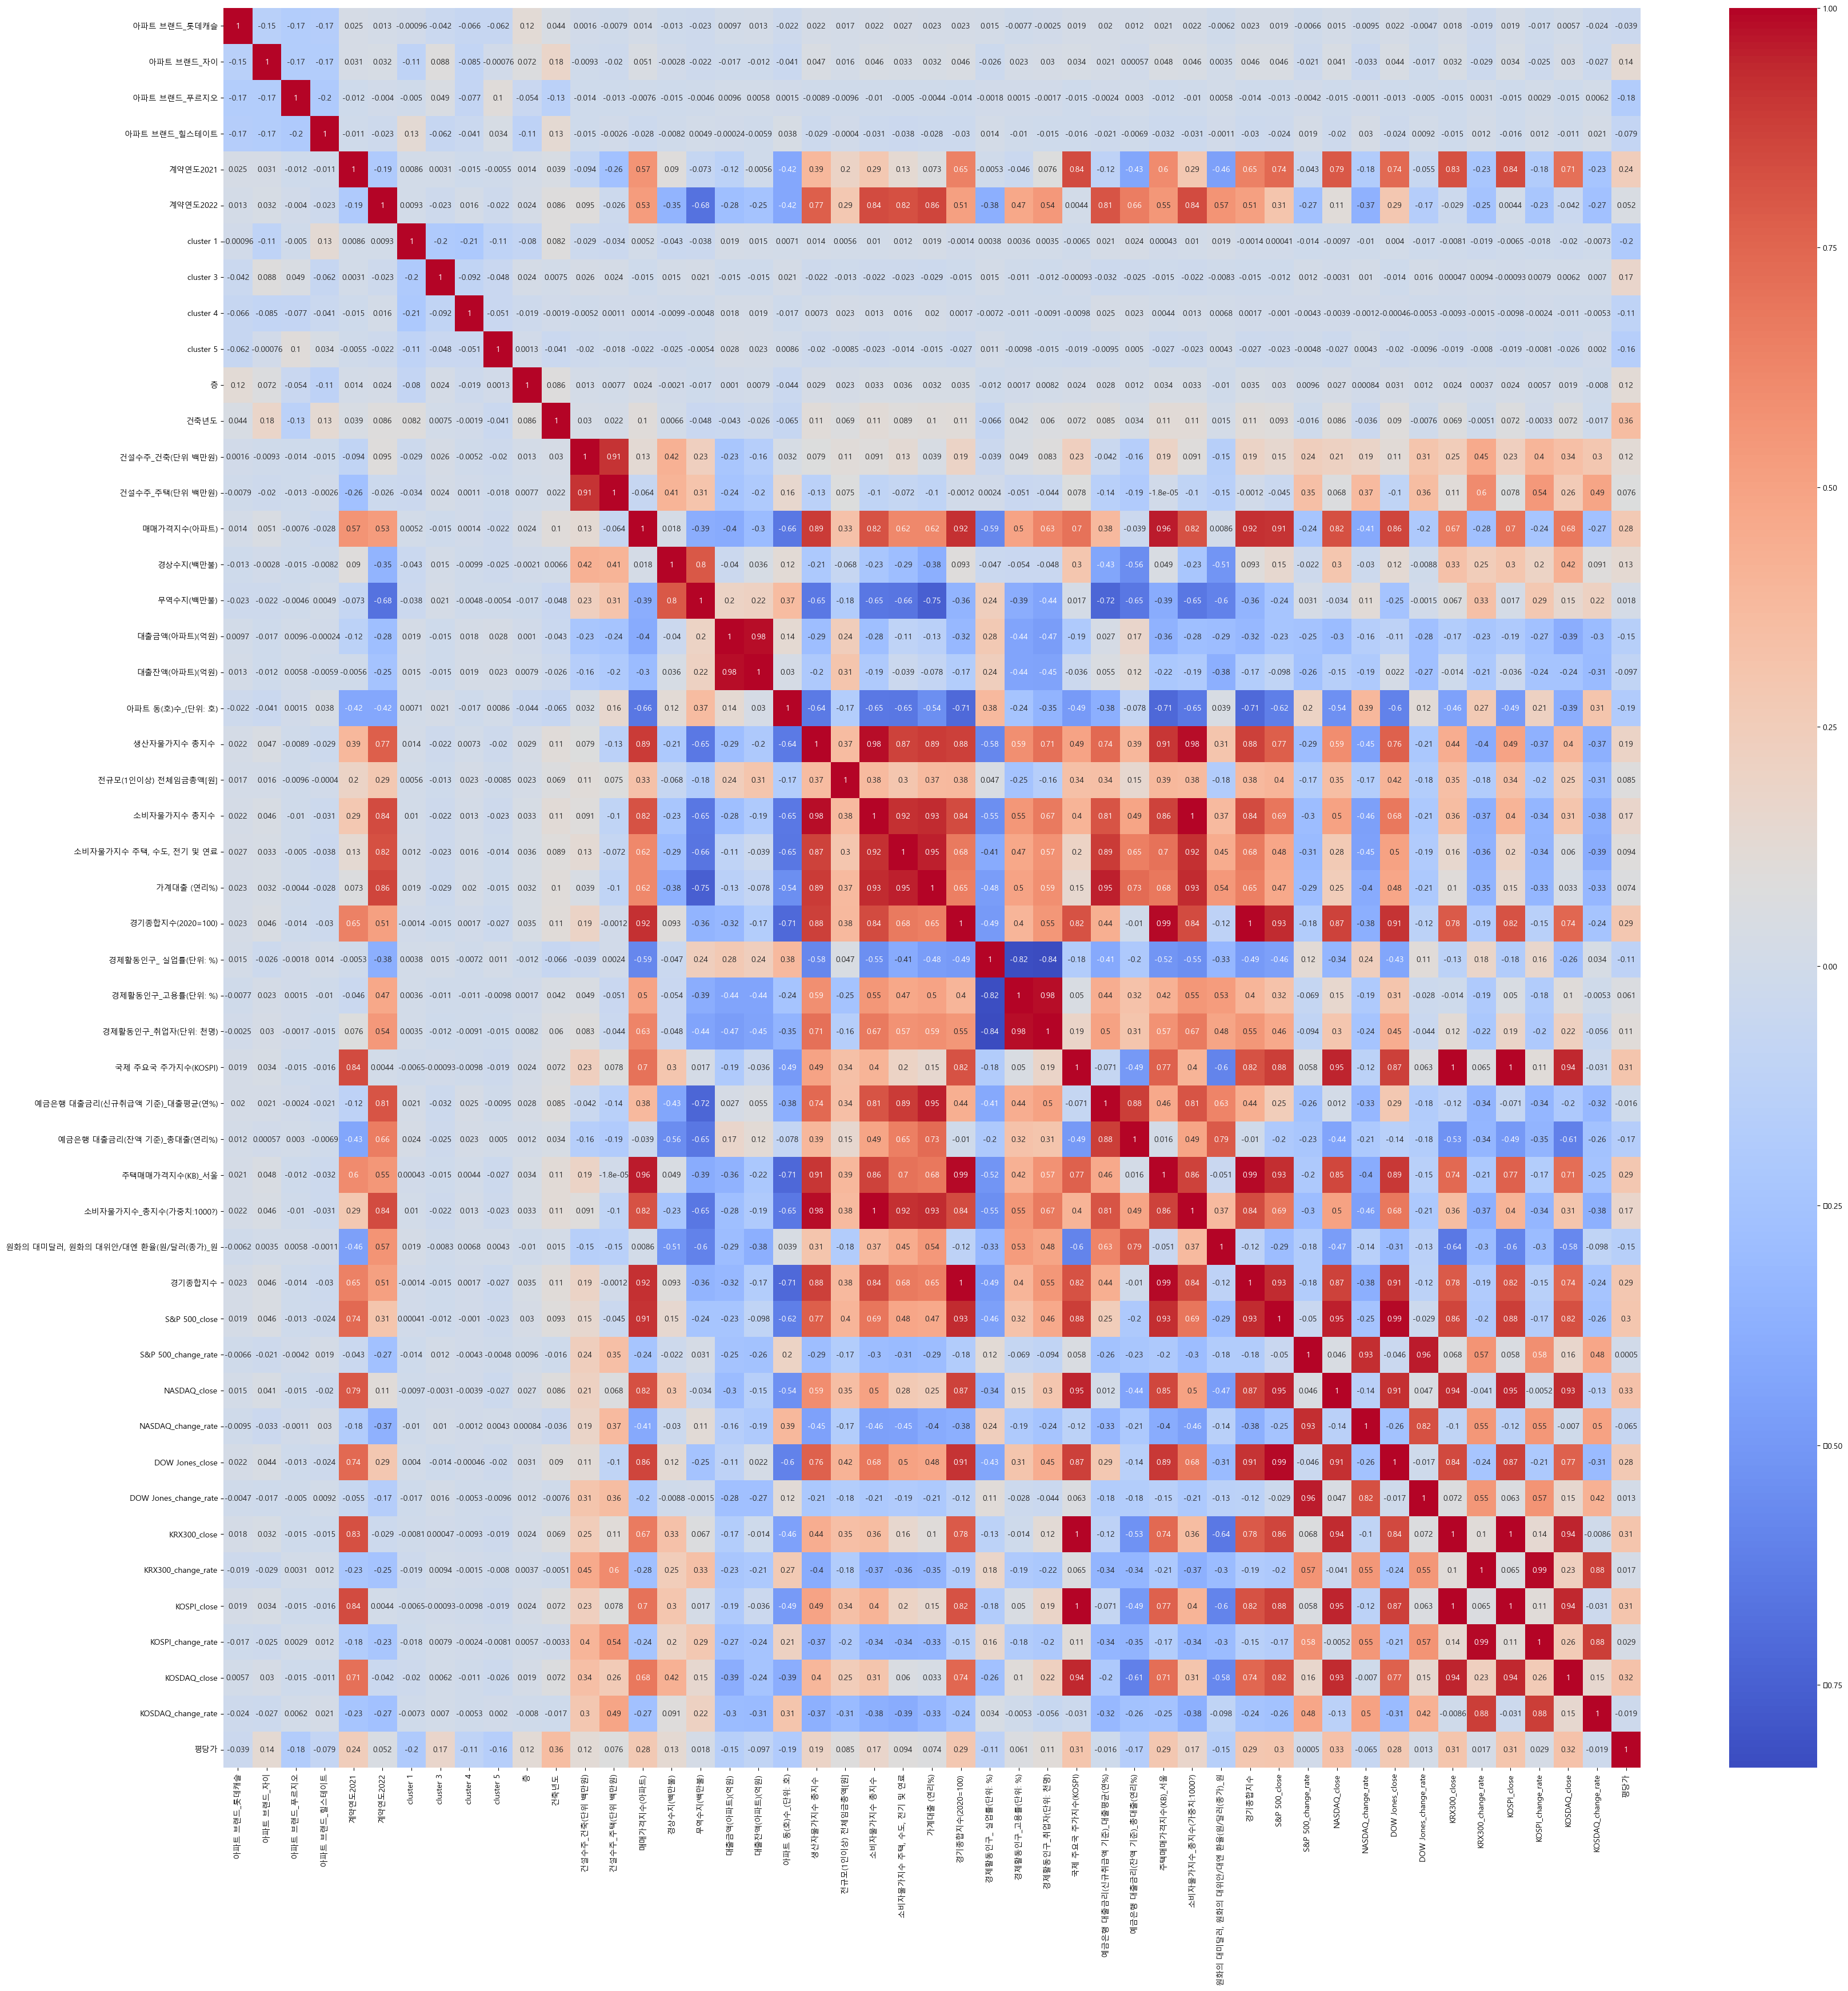

In [76]:
plt.figure(figsize=(40,40))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")

In [82]:
# 상관계수 +- 0.7 이상 값들
data_corr_index = data_corr[abs(data_corr['평당가'])>=0.7].index
data_corr_index

Index(['평당가'], dtype='object')

In [83]:
# 상관계수 +- 0.3 이상 값들
data_index = data_corr[abs(data_corr['평당가'])>=0.9].index
data_index

Index(['평당가'], dtype='object')

# 다중공선성 확인(VIF)

In [84]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

C:\Users\2001_\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,1.047660e+00,cluster 5
1,1.048095e+00,층
2,1.082576e+00,cluster 3
3,1.120357e+00,건축년도
4,1.127126e+00,cluster 4
5,1.173098e+00,cluster 1
6,1.188878e+00,아파트 브랜드_롯데캐슬
7,1.212061e+00,아파트 브랜드_푸르지오
8,1.246633e+00,아파트 브랜드_힐스테이트
9,1.251029e+00,아파트 브랜드_자이


In [85]:
vif[vif['VIF Factor']<=10]

,VIF Factor,features
0,1.047660,cluster 5
1,1.048095,층
2,1.082576,cluster 3
3,1.120357,건축년도
4,1.127126,cluster 4
5,1.173098,cluster 1
6,1.188878,아파트 브랜드_롯데캐슬
7,1.212061,아파트 브랜드_푸르지오
8,1.246633,아파트 브랜드_힐스테이트
9,1.251029,아파트 브랜드_자이


살아남는 변수가 너무 없다 -> scaler 후에 살펴보자

In [86]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_std_final.values, i) for i in range(X_std_final.shape[1])]
vif["features"] = X_std_final.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

C:\Users\2001_\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,1.047660e+00,cluster 5
1,1.048095e+00,층
2,1.082576e+00,cluster 3
3,1.120357e+00,건축년도
4,1.127126e+00,cluster 4
5,1.173098e+00,cluster 1
6,1.188878e+00,아파트 브랜드_롯데캐슬
7,1.212061e+00,아파트 브랜드_푸르지오
8,1.246633e+00,아파트 브랜드_힐스테이트
9,1.251029e+00,아파트 브랜드_자이


In [87]:
vif[vif['VIF Factor']<=10]

,VIF Factor,features
0,1.047660,cluster 5
1,1.048095,층
2,1.082576,cluster 3
3,1.120357,건축년도
4,1.127126,cluster 4
5,1.173098,cluster 1
6,1.188878,아파트 브랜드_롯데캐슬
7,1.212061,아파트 브랜드_푸르지오
8,1.246633,아파트 브랜드_힐스테이트
9,1.251029,아파트 브랜드_자이


- vif 원핫인코딩 된 컬럼들 하나씩 빼고 다시 돌리기 -> 완료
- R에서 다시 돌려보기